In [116]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

symbol = 'MSFT'
path = f'../datasets/US_stocks/{symbol}.csv' 
df = pd.read_csv(path)
df_ = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df_.index = pd.DatetimeIndex(df['Date'])
df_.columns = ['Open', f'High', f'Low', f'Close', f'Volume']
df = df_.dropna()

start = '2010-01-01'
end = '2018-01-01'
df = df.loc[(df.index >= start) & (df.index <= end)]

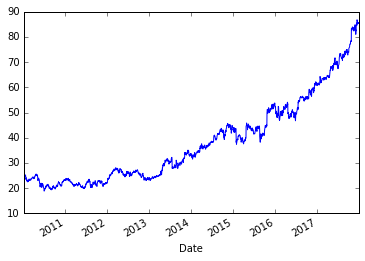

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

df['Close'].plot()

In [118]:
import backtrader as bt
from datetime import datetime


import backtrader as bt

from btbot.constants import SELL, BUY, HOLD


class CrossOverSider(bt.Indicator):
    """Cross over to determine the side for metalabeling"""
    lines = ('side',)
    params = (
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 50),
        # moving average to use
        ('_movav', bt.indicators.SMA)
    )

    def __init__(self):
        sma_fast = self.p._movav(period=self.p.fast, plot=False, subplot=False)
        sma_slow = self.p._movav(period=self.p.slow, plot=False, subplot=False)

        self.crossover = bt.indicators.CrossOver(sma_fast, sma_slow, plot=False, subplot=False)

    def next(self):
        if self.crossover[0] < 0:
            self.lines.side[0] = SELL
        elif self.crossover[0] > 0:
            self.lines.side[0] = BUY
        else:
            self.lines.side[0] = HOLD

In [163]:
from btbot.utils import print_trade_analysis
from btbot.strategies.constants import SELL, BUY, HOLD
from btbot.labelers import BarrierLabeler
from btbot.samplers import CUSUMFilter, BasicSampler
from btbot.indicators import EMAVolatility
from btbot.siders import CrossOverSider
from collections import deque
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import numpy as np
from abc import abstractmethod

from backtrader.analyzers import SharpeRatio_A, DrawDown, TradeAnalyzer, TimeFrame, Returns


model_params = {'booster': 'dart',
         'max_depth': 5, 'learning_rate': 0.1,
         'objective': 'multi:softmax', 'num_class': 3, 
         'sample_type': 'uniform',
         'rate_drop': 0.1,
         'skip_drop': 0.5,
         'silent': True}

SELL_TYPE = 'SELL'
BUY_TYPE = 'BUY'


class BaseStrategy(bt.Strategy):
    def __init__(self):
        self.count = 0 
        self.train_count = 0
        self.model = None
        
    @abstractmethod
    def observe(self):
        """Store data"""
        raise NotImplementedError()
        
    @abstractmethod
    def process(self):
        raise NotImplementedError()
        
    @abstractmethod
    def fit(self):
        raise NotImplementedError()
        
    @abstractmethod
    def predict(self, model):
        raise NotImplementedError()
        
    def execute(self, orders):
        print('orders', orders)
        for order in orders:
            pos = self.getpositionbyname('stock').size
            print('pos', pos)
            if order['type'] == SELL_TYPE:
                if pos >= 0:
                    size = order['size'] + abs(pos)
                    self.sell(data=self.stock, size=size)
            elif order['type'] == BUY_TYPE:
                if pos <= 0:
                    size = order['size'] + abs(pos)
                    self.buy(data=self.stock, size=size)
        
    @property
    def warmup(self):
        if self.count < self.p.warmup:
            return True
        else:
            return False
    
    @property
    def is_metalabeling(self):
        if self.sider is None:
            return False
        else:
            return True
        
    def next(self):
        self.observe()
        self.count += 1
        self.train_count += 1
        if self.warmup:
            return None
        if self.is_metalabeling:
            side = self.sider.side[0]
            if side == HOLD:
                return None
        if self.train_count >= self.p.train_freq:
            # Start training and prediction
            self.process()
            self.fit()
            self.train_count = 0
        if self.model is not None:
            orders = self.predict()
            self.execute(orders)

In [167]:
import pandas as pd

from finance_ml.stats import get_daily_vol
from finance_ml.labeling import cusum_filter
from finance_ml.labeling import get_t1, get_events, get_sizes


SELL = -1
HOLD = 0
BUY = 1


class MLStrategy(BaseStrategy):
    params = (
        ('warmup', 200),
        ('train_freq', 1),
        ('size', 50),
        ('debug', False),
        ('min_data', 5),
        ('max_data', 100000),
        ('timelag', 10),
        ('num_round', 50),
        ('sider', None),
        ('sider_params', dict()),
        ('sampler', BasicSampler),
        ('sampler_params', dict()),
        ('labeler', BarrierLabeler),
        ('labeler_params', dict(period=20, devfactor=1, forward=5)))

    def __init__(self):
        super(MLStrategy, self).__init__()
        self.stock = self.getdatabyname('stock')
        '''
        self.sampler = self.p.sampler(**self.p.sampler_params)
        if self.p.sider:
            self.p.labeler_params['sider'] = self.p.sider
            self.p.labeler_params['sider_params'] = self.p.sider_params
            sider = self.p.sider(**self.p.sider_params)
        else:
            self.p.labeler_params['sider'] = None
        self.labeler = self.p.labeler(**self.p.labeler_params)
        '''
        # Sider
        if self.p.sider is None:
            self.sider = None
        else:
            self.sider = self.p.sider(**self.p.sider_params)
        if self.is_metalabeling:
            self.features = {SELL: deque(maxlen=self.p.max_data),
                             BUY: deque(maxlen=self.p.max_data),
                             HOLD: deque(maxlen=self.p.max_data)}
            self.targets = {SELL: deque(maxlen=self.p.max_data),
                            BUY: deque(maxlen=self.p.max_data),
                            HOLD: deque(maxlen=self.p.max_data)}
        else:
            self.features = deque(maxlen=self.p.max_data)
            self.targets = deque(maxlen=self.p.max_data)
        self.vol_lines = EMAVolatility().lines.vol
        self.scaler = StandardScaler()
        self.samples = []
        self.prices = []
        self.sides = []
        self.vols = []
        self.timestamps = []
        self.observations = []
        
    def observe(self):
        # Store features
        features = []
        features.append(np.array(self.stock.close.get(size=self.p.timelag)) / self.stock.close[0])
        features.append(np.array(self.stock.volume.get(size=self.p.timelag)) / self.stock.volume[0])
        self.current_features = np.hstack(features)
        if len(self.current_features) == 0:
            return None
        self.observations.append(self.current_features)
        # Store time stamps
        self.timestamps.append(bt.utils.date.num2date(self.stock.datetime[0]))
        # Store prices and volatility for labeling
        price = self.stock.close[0]
        self.prices.append(price)
        self.vols.append(self.vol_lines[0])
        # Store sides for metalabeling
        if self.is_metalabeling:
            side = self.sider.side[0]
            self.sides.append(side)
            
    def process(self):
        timestamps = pd.DatetimeIndex(self.timestamps)
        observations = pd.DataFrame(np.array(self.observations),
                                    index=timestamps)
        prices = pd.Series(self.prices, index=timestamps)
        vols = pd.Series(self.vols, index=timestamps)
        # Subsampling
        h = prices * vols
        sampled_timestamps = prices.index # cusum_filter(prices, h)
        # Labeling
        t1 = get_t1(prices, sampled_timestamps, 5)
        if self.is_metalabeling:
            sides = pd.Series(self.sides, index=timestamps)
        else:
            sides = None
        try:
            events = get_events(prices, sampled_timestamps, [1, 1], vols, min_ret=0,
                            num_threads=16, t1=t1, side=sides)
            labels = get_sizes(prices, events, sign_label=False)
        except:
            return None
        if self.is_metalabeling:
            times = []
            for side in [SELL, HOLD, BUY]:
                _labels = labels.loc[labels['side'] == side]
                self.targets[side] += list(_labels['size'].values)
                self.features[side] += list(observations.loc[_labels.index].values)
                if len(_labels) > 0:
                    times.append(_labels.index[-1])
            max_time = max(times)
        else:
            self.targets += list(labels['size'].values + 1)
            self.features += list(observations.loc[labels.index].values)
            max_time = labels.index[-1]
        # Discard labeled data
        new_timestamps = labels.loc[labels.index > max_time].index
        if len(new_timestamps) > 0:
            self.observations = list(observations.loc[new_timestamps].values)
            self.prices = list(prices.loc[new_timestamps].values)
            self.vols = list(vols.loc[new_timestamps].values)
            self.timestamps = list(new_timestamps)
            if self.is_metalabeling:
                self.sides = list(sides.loc[new_timestamps])
        else:
            self.observations = list()
            self.prices = list()
            self.vols = list()
            self.timestamps = list()
            if self.is_metalabeling:
                self.sides = list()
            
        
    def fit(self):
        if self.is_metalabeling:
            side = self.sider.side[0]
            targets = np.array(self.targets[side]).astype(int)
            features = np.array(self.features[side])
        else:
            targets = np.array(self.targets).astype(int)
            features = np.array(self.features)
        if len(features) == 0:
            return None
        features = self.scaler.fit_transform(features)
        dtrain = xgb.DMatrix(features, label=targets)
        self.model = xgb.train(model_params, dtrain, self.p.num_round)
    
    def predict(self):
        # Prediction
        pred_features = np.array([self.current_features])
        pred_features = self.scaler.transform(pred_features)
        dtest = xgb.DMatrix(pred_features)
        signal = int(self.model.predict(dtest)[0] - 1)
        if self.is_metalabeling:
            side = self.sider.side[0]
            if side == SELL and signal == 1:
                order = [{'type': SELL_TYPE, 'size': self.p.size}]
            elif side == BUY and signal == 1:
                order = [{'type': BUY_TYPE, 'size': self.p.size}]
            else:
                order = []
        else:
            if signal == SELL:
                order = [{'type': SELL_TYPE, 'size': self.p.size}]
            elif signal == BUY:
                order = [{'type': BUY_TYPE, 'size': self.p.size}]
            else:
                order = []
        return order
    
    def notify_trade(self, trade):
        if trade.isclosed:
            dt = self.data.datetime.date()
 
            print('---------------------------- TRADE ---------------------------------')
            print("1: Data Name:                            {}".format(trade.data._name))
            print("2: Bar Num:                              {}".format(len(trade.data)))
            print("3: Current date:                         {}".format(dt))
            print('4: Status:                               Trade Complete')
            print('5: Ref:                                  {}'.format(trade.ref))
            print('6: PnL:                                  {}'.format(round(trade.pnl,2)))
            print('--------------------------------------------------------------------')
            
    def print_result(self):
        print_trade_analysis(self)

In [168]:
from btbot.cerebro import Cerebro


def get_cerebro(startcash=10000):
    cerebro = Cerebro()
    cerebro.broker.setcash(startcash)
    # cerebro.addanalyzer(TradeAnalyzer, _name='trade')
    # cerebro.addanalyzer(DrawDown, _name='drawdown')
    # cerebro.addanalyzer(SharpeRatio_A, _name='sharpe', timeframe=TimeFrame.Days)
    # cerebro.addanalyzer(Returns, _name='returns', timeframe=TimeFrame.Days)
    # cerebro.addobserver(bt.observers.DrawDown)
    return cerebro

In [169]:
%%time

cerebro = get_cerebro()

stock = bt.feeds.PandasData(dataname=df, close=0, volume=1)
cerebro.adddata(stock, name='stock')
#  cerebro.adddata(macro, name='macro')
# sampler = CUSUMFilter
# sampler_params = dict(period=20, devfactor=1)
# sider = CrossOverSider
sider = None
sider_params = dict(slow=30, fast=10)
labeler = BarrierLabeler
labeler_params = dict(period=20, devfactor=1.0, horizon=5)
cerebro.addstrategy(MLStrategy, sider=sider, sider_params=sider_params, size=100,
                    labeler=labeler, labeler_params=labeler_params)
strategy = cerebro.run()[0]

2018-09-15 02:20:46.470654 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 0


2018-09-15 02:20:47.118085 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:20:47.680947 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              203
3: Current date:                         2010-10-21
4: Status:                               Trade Complete
5: Ref:                                  91
6: PnL:                                  14.84
--------------------------------------------------------------------


2018-09-15 02:20:48.223014 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:49.029337 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:49.546233 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:50.292078 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              207
3: Current date:                         2010-10-27
4: Status:                               Trade Complete
5: Ref:                                  92
6: PnL:                                  -28.03
--------------------------------------------------------------------


2018-09-15 02:20:50.864110 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:20:51.379336 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:20:51.928557 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:20:52.507895 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              211
3: Current date:                         2010-11-02
4: Status:                               Trade Complete
5: Ref:                                  93
6: PnL:                                  104.71
--------------------------------------------------------------------


2018-09-15 02:20:53.198796 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:53.886651 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:54.594310 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:55.201843 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:55.840475 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              216
3: Current date:                         2010-11-09
4: Status:                               Trade Complete
5: Ref:                                  94
6: PnL:                                  20.61
--------------------------------------------------------------------


2018-09-15 02:20:56.418011 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              217
3: Current date:                         2010-11-10
4: Status:                               Trade Complete
5: Ref:                                  95
6: PnL:                                  16.49
--------------------------------------------------------------------


2018-09-15 02:20:56.966778 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:57.487662 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:20:58.067195 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:58.766023 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:20:59.323214 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              222
3: Current date:                         2010-11-17
4: Status:                               Trade Complete
5: Ref:                                  96
6: PnL:                                  78.28
--------------------------------------------------------------------


2018-09-15 02:20:59.825085 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:21:00.642332 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:21:01.137316 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              225
3: Current date:                         2010-11-22
4: Status:                               Trade Complete
5: Ref:                                  97
6: PnL:                                  -20.74
--------------------------------------------------------------------


2018-09-15 02:21:01.694923 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              226
3: Current date:                         2010-11-23
4: Status:                               Trade Complete
5: Ref:                                  98
6: PnL:                                  6.64
--------------------------------------------------------------------


2018-09-15 02:21:02.327518 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:21:02.846824 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:21:03.385522 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              229
3: Current date:                         2010-11-29
4: Status:                               Trade Complete
5: Ref:                                  99
6: PnL:                                  -31.52
--------------------------------------------------------------------


2018-09-15 02:21:03.902853 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:10.123674 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              231
3: Current date:                         2010-12-01
4: Status:                               Trade Complete
5: Ref:                                  100
6: PnL:                                  -31.52
--------------------------------------------------------------------


2018-09-15 02:41:11.001935 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:41:11.577242 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:41:12.077523 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:12.639914 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              235
3: Current date:                         2010-12-07
4: Status:                               Trade Complete
5: Ref:                                  101
6: PnL:                                  125.27
--------------------------------------------------------------------


2018-09-15 02:41:13.154236 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:13.625013 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:14.169080 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:14.667955 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:15.174554 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:15.780108 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:16.577645 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:17.085171 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:17.658522 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:18.233002 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:19.608216 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:20.833369 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:21.696602 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100
orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:22.312005 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.
2018-09-15 02:41:22.772977 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:23.396421 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:24.067331 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:24.719023 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:25.454547 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              254
3: Current date:                         2011-01-04
4: Status:                               Trade Complete
5: Ref:                                  102
6: PnL:                                  -71.34
--------------------------------------------------------------------


2018-09-15 02:41:26.008940 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              255
3: Current date:                         2011-01-05
4: Status:                               Trade Complete
5: Ref:                                  103
6: PnL:                                  -3.32
--------------------------------------------------------------------


2018-09-15 02:41:26.715430 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:27.519600 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              257
3: Current date:                         2011-01-07
4: Status:                               Trade Complete
5: Ref:                                  104
6: PnL:                                  -61.39
--------------------------------------------------------------------


2018-09-15 02:41:28.253580 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:29.793151 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:30.412454 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              260
3: Current date:                         2011-01-12
4: Status:                               Trade Complete
5: Ref:                                  105
6: PnL:                                  -43.14
--------------------------------------------------------------------


2018-09-15 02:41:31.047298 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              261
3: Current date:                         2011-01-13
4: Status:                               Trade Complete
5: Ref:                                  106
6: PnL:                                  -17.42
--------------------------------------------------------------------


2018-09-15 02:41:32.464916 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:33.849144 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:41:35.401919 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:41:37.183832 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:38.426397 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:39.800630 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:41.418429 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:41:43.533867 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:44.765943 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:46.188595 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:47.851584 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:41:49.475116 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              273
3: Current date:                         2011-02-01
4: Status:                               Trade Complete
5: Ref:                                  107
6: PnL:                                  -43.97
--------------------------------------------------------------------


2018-09-15 02:41:51.061687 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:53.048374 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              275
3: Current date:                         2011-02-03
4: Status:                               Trade Complete
5: Ref:                                  108
6: PnL:                                  -13.69
--------------------------------------------------------------------


2018-09-15 02:41:54.358646 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              276
3: Current date:                         2011-02-04
4: Status:                               Trade Complete
5: Ref:                                  109
6: PnL:                                  -21.98
--------------------------------------------------------------------


2018-09-15 02:41:55.843451 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:56.674191 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              278
3: Current date:                         2011-02-08
4: Status:                               Trade Complete
5: Ref:                                  110
6: PnL:                                  -33.18
--------------------------------------------------------------------


2018-09-15 02:41:57.463721 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              279
3: Current date:                         2011-02-09
4: Status:                               Trade Complete
5: Ref:                                  111
6: PnL:                                  7.47
--------------------------------------------------------------------


2018-09-15 02:41:58.090756 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:58.857316 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:41:59.435735 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              282
3: Current date:                         2011-02-14
4: Status:                               Trade Complete
5: Ref:                                  112
6: PnL:                                  81.71
--------------------------------------------------------------------


2018-09-15 02:41:59.927828 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              283
3: Current date:                         2011-02-15
4: Status:                               Trade Complete
5: Ref:                                  113
6: PnL:                                  -0.38
--------------------------------------------------------------------


2018-09-15 02:42:00.463449 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:01.997615 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:02.650563 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:03.508243 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:04.219028 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:04.710968 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:05.332100 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              290
3: Current date:                         2011-02-25
4: Status:                               Trade Complete
5: Ref:                                  114
6: PnL:                                  10.85
--------------------------------------------------------------------


2018-09-15 02:42:05.882112 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              291
3: Current date:                         2011-02-28
4: Status:                               Trade Complete
5: Ref:                                  115
6: PnL:                                  -18.36
--------------------------------------------------------------------


2018-09-15 02:42:06.394753 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:06.907804 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:07.448756 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:07.947684 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:08.438381 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              296
3: Current date:                         2011-03-07
4: Status:                               Trade Complete
5: Ref:                                  116
6: PnL:                                  46.73
--------------------------------------------------------------------


2018-09-15 02:42:08.962459 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:09.501914 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:10.028150 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              299
3: Current date:                         2011-03-10
4: Status:                               Trade Complete
5: Ref:                                  117
6: PnL:                                  -42.56
--------------------------------------------------------------------


2018-09-15 02:42:10.551925 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:11.137432 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              301
3: Current date:                         2011-03-14
4: Status:                               Trade Complete
5: Ref:                                  118
6: PnL:                                  10.85
--------------------------------------------------------------------


2018-09-15 02:42:11.637162 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:12.150963 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:12.643850 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              304
3: Current date:                         2011-03-17
4: Status:                               Trade Complete
5: Ref:                                  119
6: PnL:                                  -35.88
--------------------------------------------------------------------


2018-09-15 02:42:13.175255 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:14.444875 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              306
3: Current date:                         2011-03-21
4: Status:                               Trade Complete
5: Ref:                                  120
6: PnL:                                  -10.01
--------------------------------------------------------------------


2018-09-15 02:42:15.392958 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:16.053330 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              308
3: Current date:                         2011-03-23
4: Status:                               Trade Complete
5: Ref:                                  121
6: PnL:                                  4.17
--------------------------------------------------------------------


2018-09-15 02:42:16.586875 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              309
3: Current date:                         2011-03-24
4: Status:                               Trade Complete
5: Ref:                                  122
6: PnL:                                  -30.88
--------------------------------------------------------------------


2018-09-15 02:42:17.102072 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:17.637922 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:18.136535 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:18.629119 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:19.124762 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              314
3: Current date:                         2011-03-31
4: Status:                               Trade Complete
5: Ref:                                  123
6: PnL:                                  0.0
--------------------------------------------------------------------


2018-09-15 02:42:19.659024 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:20.101415 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:20.612576 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              317
3: Current date:                         2011-04-05
4: Status:                               Trade Complete
5: Ref:                                  124
6: PnL:                                  -18.36
--------------------------------------------------------------------


2018-09-15 02:42:21.071459 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:21.702638 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:22.214896 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:22.747899 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:23.289507 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:23.850414 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:24.359566 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:24.881474 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              325
3: Current date:                         2011-04-15
4: Status:                               Trade Complete
5: Ref:                                  125
6: PnL:                                  -30.04
--------------------------------------------------------------------


2018-09-15 02:42:25.420816 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:25.934567 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:26.454779 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              328
3: Current date:                         2011-04-20
4: Status:                               Trade Complete
5: Ref:                                  126
6: PnL:                                  -6.68
--------------------------------------------------------------------


2018-09-15 02:42:26.964865 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:27.468597 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              330
3: Current date:                         2011-04-25
4: Status:                               Trade Complete
5: Ref:                                  127
6: PnL:                                  1.67
--------------------------------------------------------------------


2018-09-15 02:42:27.970696 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:28.515795 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              332
3: Current date:                         2011-04-27
4: Status:                               Trade Complete
5: Ref:                                  128
6: PnL:                                  -61.75
--------------------------------------------------------------------


2018-09-15 02:42:29.039286 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:29.531524 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:30.140371 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:30.692416 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:31.339278 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:31.883679 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:32.607847 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              339
3: Current date:                         2011-05-06
4: Status:                               Trade Complete
5: Ref:                                  129
6: PnL:                                  -19.19
--------------------------------------------------------------------


2018-09-15 02:42:33.172889 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:33.742044 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:34.404181 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              342
3: Current date:                         2011-05-11
4: Status:                               Trade Complete
5: Ref:                                  130
6: PnL:                                  35.05
--------------------------------------------------------------------


2018-09-15 02:42:34.976887 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              343
3: Current date:                         2011-05-12
4: Status:                               Trade Complete
5: Ref:                                  131
6: PnL:                                  -25.04
--------------------------------------------------------------------


2018-09-15 02:42:35.573151 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:36.406095 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:37.020571 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:37.514191 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              347
3: Current date:                         2011-05-18
4: Status:                               Trade Complete
5: Ref:                                  132
6: PnL:                                  55.07
--------------------------------------------------------------------


2018-09-15 02:42:39.027520 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:40.278593 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              349
3: Current date:                         2011-05-20
4: Status:                               Trade Complete
5: Ref:                                  133
6: PnL:                                  15.96
--------------------------------------------------------------------


2018-09-15 02:42:41.055316 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:41.641526 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:42.201338 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              352
3: Current date:                         2011-05-25
4: Status:                               Trade Complete
5: Ref:                                  134
6: PnL:                                  46.2
--------------------------------------------------------------------


2018-09-15 02:42:42.752573 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:43.238853 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:43.779749 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:44.344988 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:45.138677 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:45.953877 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:46.505823 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:47.087861 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              360
3: Current date:                         2011-06-07
4: Status:                               Trade Complete
5: Ref:                                  135
6: PnL:                                  -6.72
--------------------------------------------------------------------


2018-09-15 02:42:47.628566 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:48.112587 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:48.735707 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:49.217199 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:49.698465 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:50.197414 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:50.667676 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:51.190363 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              368
3: Current date:                         2011-06-17
4: Status:                               Trade Complete
5: Ref:                                  136
6: PnL:                                  -10.92
--------------------------------------------------------------------


2018-09-15 02:42:51.779859 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:52.371659 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:42:52.959542 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:53.493976 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              372
3: Current date:                         2011-06-23
4: Status:                               Trade Complete
5: Ref:                                  137
6: PnL:                                  18.48
--------------------------------------------------------------------


2018-09-15 02:42:54.078624 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:54.594512 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:55.421364 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              375
3: Current date:                         2011-06-28
4: Status:                               Trade Complete
5: Ref:                                  138
6: PnL:                                  -72.24
--------------------------------------------------------------------


2018-09-15 02:42:55.968588 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:42:56.415721 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              377
3: Current date:                         2011-06-30
4: Status:                               Trade Complete
5: Ref:                                  139
6: PnL:                                  36.96
--------------------------------------------------------------------


2018-09-15 02:42:56.946403 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:57.534512 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:58.143080 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:42:58.699768 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              381
3: Current date:                         2011-07-07
4: Status:                               Trade Complete
5: Ref:                                  140
6: PnL:                                  -63.0
--------------------------------------------------------------------


2018-09-15 02:42:59.241819 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              382
3: Current date:                         2011-07-08
4: Status:                               Trade Complete
5: Ref:                                  141
6: PnL:                                  4.2
--------------------------------------------------------------------


2018-09-15 02:42:59.752878 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:00.335124 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:00.988100 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:02.732928 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:03.331188 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:03.842742 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:05.259767 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:06.939622 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              390
3: Current date:                         2011-07-20
4: Status:                               Trade Complete
5: Ref:                                  142
6: PnL:                                  -62.16
--------------------------------------------------------------------


2018-09-15 02:43:07.777059 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              391
3: Current date:                         2011-07-21
4: Status:                               Trade Complete
5: Ref:                                  143
6: PnL:                                  -20.16
--------------------------------------------------------------------


2018-09-15 02:43:08.404076 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:09.640910 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              393
3: Current date:                         2011-07-25
4: Status:                               Trade Complete
5: Ref:                                  144
6: PnL:                                  -18.48
--------------------------------------------------------------------


2018-09-15 02:43:10.257946 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:10.790375 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              395
3: Current date:                         2011-07-27
4: Status:                               Trade Complete
5: Ref:                                  145
6: PnL:                                  52.08
--------------------------------------------------------------------


2018-09-15 02:43:11.786235 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:12.642106 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              397
3: Current date:                         2011-07-29
4: Status:                               Trade Complete
5: Ref:                                  146
6: PnL:                                  30.24
--------------------------------------------------------------------


2018-09-15 02:43:13.831950 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              398
3: Current date:                         2011-08-01
4: Status:                               Trade Complete
5: Ref:                                  147
6: PnL:                                  -0.84
--------------------------------------------------------------------


2018-09-15 02:43:14.375539 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:14.931893 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:15.471540 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:16.040375 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:17.167416 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              403
3: Current date:                         2011-08-08
4: Status:                               Trade Complete
5: Ref:                                  148
6: PnL:                                  209.15
--------------------------------------------------------------------


2018-09-15 02:43:18.513537 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              404
3: Current date:                         2011-08-09
4: Status:                               Trade Complete
5: Ref:                                  149
6: PnL:                                  -26.04
--------------------------------------------------------------------


2018-09-15 02:43:19.442696 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              405
3: Current date:                         2011-08-10
4: Status:                               Trade Complete
5: Ref:                                  150
6: PnL:                                  -20.16
--------------------------------------------------------------------


2018-09-15 02:43:19.955571 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              406
3: Current date:                         2011-08-11
4: Status:                               Trade Complete
5: Ref:                                  151
6: PnL:                                  -37.8
--------------------------------------------------------------------


2018-09-15 02:43:20.493852 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              407
3: Current date:                         2011-08-12
4: Status:                               Trade Complete
5: Ref:                                  152
6: PnL:                                  -52.92
--------------------------------------------------------------------


2018-09-15 02:43:20.963845 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:21.562652 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:22.110406 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:22.676673 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              411
3: Current date:                         2011-08-18
4: Status:                               Trade Complete
5: Ref:                                  153
6: PnL:                                  -34.01
--------------------------------------------------------------------


2018-09-15 02:43:23.198554 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:23.759978 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:24.298824 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:24.823902 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:25.357403 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:25.887117 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              417
3: Current date:                         2011-08-26
4: Status:                               Trade Complete
5: Ref:                                  154
6: PnL:                                  5.07
--------------------------------------------------------------------


2018-09-15 02:43:26.419342 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:26.964406 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:27.464011 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              420
3: Current date:                         2011-08-31
4: Status:                               Trade Complete
5: Ref:                                  155
6: PnL:                                  150.45
--------------------------------------------------------------------


2018-09-15 02:43:28.007143 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              421
3: Current date:                         2011-09-01
4: Status:                               Trade Complete
5: Ref:                                  156
6: PnL:                                  -14.37
--------------------------------------------------------------------


2018-09-15 02:43:28.550529 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              422
3: Current date:                         2011-09-02
4: Status:                               Trade Complete
5: Ref:                                  157
6: PnL:                                  -57.48
--------------------------------------------------------------------


2018-09-15 02:43:29.067997 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:29.628175 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:30.138264 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:30.652357 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              426
3: Current date:                         2011-09-09
4: Status:                               Trade Complete
5: Ref:                                  158
6: PnL:                                  -18.6
--------------------------------------------------------------------


2018-09-15 02:43:31.204160 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              427
3: Current date:                         2011-09-12
4: Status:                               Trade Complete
5: Ref:                                  159
6: PnL:                                  -33.39
--------------------------------------------------------------------


2018-09-15 02:43:31.746520 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:32.278597 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:32.791854 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:33.331566 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:33.824828 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:34.383778 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              433
3: Current date:                         2011-09-20
4: Status:                               Trade Complete
5: Ref:                                  160
6: PnL:                                  -144.11
--------------------------------------------------------------------


2018-09-15 02:43:34.942604 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              434
3: Current date:                         2011-09-21
4: Status:                               Trade Complete
5: Ref:                                  161
6: PnL:                                  -21.98
--------------------------------------------------------------------


2018-09-15 02:43:35.529422 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:36.084481 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:36.618967 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:37.157043 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:37.686441 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              439
3: Current date:                         2011-09-28
4: Status:                               Trade Complete
5: Ref:                                  162
6: PnL:                                  94.67
--------------------------------------------------------------------


2018-09-15 02:43:38.217589 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              440
3: Current date:                         2011-09-29
4: Status:                               Trade Complete
5: Ref:                                  163
6: PnL:                                  4.23
--------------------------------------------------------------------


2018-09-15 02:43:38.721788 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:39.315822 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              442
3: Current date:                         2011-10-03
4: Status:                               Trade Complete
5: Ref:                                  164
6: PnL:                                  106.5
--------------------------------------------------------------------


2018-09-15 02:43:39.801552 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:40.335589 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:40.898775 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:41.527148 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              446
3: Current date:                         2011-10-07
4: Status:                               Trade Complete
5: Ref:                                  165
6: PnL:                                  136.93
--------------------------------------------------------------------


2018-09-15 02:43:42.040672 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:42.567957 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:43.073792 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:43.577219 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:44.072899 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              451
3: Current date:                         2011-10-14
4: Status:                               Trade Complete
5: Ref:                                  166
6: PnL:                                  -81.99
--------------------------------------------------------------------


2018-09-15 02:43:44.671018 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              452
3: Current date:                         2011-10-17
4: Status:                               Trade Complete
5: Ref:                                  167
6: PnL:                                  -16.58
--------------------------------------------------------------------


2018-09-15 02:43:45.175371 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:46.228252 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:46.782448 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:47.366320 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:48.274642 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:49.147771 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              458
3: Current date:                         2011-10-25
4: Status:                               Trade Complete
5: Ref:                                  168
6: PnL:                                  2.87
--------------------------------------------------------------------


2018-09-15 02:43:49.670069 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:50.227802 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              460
3: Current date:                         2011-10-27
4: Status:                               Trade Complete
5: Ref:                                  169
6: PnL:                                  4.23
--------------------------------------------------------------------


2018-09-15 02:43:50.773668 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              461
3: Current date:                         2011-10-28
4: Status:                               Trade Complete
5: Ref:                                  170
6: PnL:                                  -0.85
--------------------------------------------------------------------


2018-09-15 02:43:51.317297 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:51.814508 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              463
3: Current date:                         2011-11-01
4: Status:                               Trade Complete
5: Ref:                                  171
6: PnL:                                  -80.3
--------------------------------------------------------------------


2018-09-15 02:43:52.319742 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:43:52.893244 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              465
3: Current date:                         2011-11-03
4: Status:                               Trade Complete
5: Ref:                                  172
6: PnL:                                  -4.23
--------------------------------------------------------------------


2018-09-15 02:43:53.494865 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              466
3: Current date:                         2011-11-04
4: Status:                               Trade Complete
5: Ref:                                  173
6: PnL:                                  11.83
--------------------------------------------------------------------


2018-09-15 02:43:54.021389 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:54.561623 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              468
3: Current date:                         2011-11-08
4: Status:                               Trade Complete
5: Ref:                                  174
6: PnL:                                  -53.25
--------------------------------------------------------------------


2018-09-15 02:43:55.091749 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:43:55.645024 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              470
3: Current date:                         2011-11-10
4: Status:                               Trade Complete
5: Ref:                                  175
6: PnL:                                  -45.64
--------------------------------------------------------------------


2018-09-15 02:43:56.159954 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:56.695133 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              472
3: Current date:                         2011-11-14
4: Status:                               Trade Complete
5: Ref:                                  176
6: PnL:                                  -34.65
--------------------------------------------------------------------


2018-09-15 02:43:57.224781 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              473
3: Current date:                         2011-11-15
4: Status:                               Trade Complete
5: Ref:                                  177
6: PnL:                                  -10.25
--------------------------------------------------------------------


2018-09-15 02:43:57.790612 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              474
3: Current date:                         2011-11-16
4: Status:                               Trade Complete
5: Ref:                                  178
6: PnL:                                  7.66
--------------------------------------------------------------------


2018-09-15 02:43:58.308179 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              475
3: Current date:                         2011-11-17
4: Status:                               Trade Complete
5: Ref:                                  179
6: PnL:                                  -39.17
--------------------------------------------------------------------


2018-09-15 02:43:58.819760 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:43:59.405528 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              477
3: Current date:                         2011-11-21
4: Status:                               Trade Complete
5: Ref:                                  180
6: PnL:                                  65.57
--------------------------------------------------------------------


2018-09-15 02:43:59.919856 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:00.472201 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:00.997944 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:01.512314 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:02.068949 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:02.588469 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:03.111068 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:03.671960 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              485
3: Current date:                         2011-12-02
4: Status:                               Trade Complete
5: Ref:                                  181
6: PnL:                                  29.8
--------------------------------------------------------------------


2018-09-15 02:44:04.224668 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:04.768308 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:44:05.347557 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:44:05.873093 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:06.415582 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              490
3: Current date:                         2011-12-09
4: Status:                               Trade Complete
5: Ref:                                  182
6: PnL:                                  5.96
--------------------------------------------------------------------


2018-09-15 02:44:07.005153 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              491
3: Current date:                         2011-12-12
4: Status:                               Trade Complete
5: Ref:                                  183
6: PnL:                                  -9.37
--------------------------------------------------------------------


2018-09-15 02:44:07.613507 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              492
3: Current date:                         2011-12-13
4: Status:                               Trade Complete
5: Ref:                                  184
6: PnL:                                  -28.95
--------------------------------------------------------------------


2018-09-15 02:44:08.135598 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:08.864631 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:09.369278 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:09.897303 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:10.453016 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:11.022972 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:11.556353 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:12.092880 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:12.632992 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              501
3: Current date:                         2011-12-27
4: Status:                               Trade Complete
5: Ref:                                  185
6: PnL:                                  17.88
--------------------------------------------------------------------


2018-09-15 02:44:13.206640 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              502
3: Current date:                         2011-12-28
4: Status:                               Trade Complete
5: Ref:                                  186
6: PnL:                                  -12.77
--------------------------------------------------------------------


2018-09-15 02:44:13.708593 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:14.238389 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:14.757124 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:15.266937 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:15.771993 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:16.318004 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              508
3: Current date:                         2012-01-06
4: Status:                               Trade Complete
5: Ref:                                  187
6: PnL:                                  120.92
--------------------------------------------------------------------


2018-09-15 02:44:16.825836 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:44:17.366725 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              510
3: Current date:                         2012-01-10
4: Status:                               Trade Complete
5: Ref:                                  188
6: PnL:                                  -34.06
--------------------------------------------------------------------


2018-09-15 02:44:17.884927 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:18.406371 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:18.957052 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:19.491714 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:20.051879 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:20.625907 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:21.191123 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:21.715756 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:22.336593 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:22.957058 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              520
3: Current date:                         2012-01-25
4: Status:                               Trade Complete
5: Ref:                                  189
6: PnL:                                  97.08
--------------------------------------------------------------------


2018-09-15 02:44:23.522064 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              521
3: Current date:                         2012-01-26
4: Status:                               Trade Complete
5: Ref:                                  190
6: PnL:                                  -45.98
--------------------------------------------------------------------


2018-09-15 02:44:24.183826 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:24.875808 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              523
3: Current date:                         2012-01-30
4: Status:                               Trade Complete
5: Ref:                                  191
6: PnL:                                  -54.5
--------------------------------------------------------------------


2018-09-15 02:44:25.639980 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              524
3: Current date:                         2012-01-31
4: Status:                               Trade Complete
5: Ref:                                  192
6: PnL:                                  -58.76
--------------------------------------------------------------------


2018-09-15 02:44:26.238513 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:26.802002 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:27.380425 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:27.997795 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:28.540687 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:29.172137 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:29.720542 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:30.269959 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:30.762635 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:31.309146 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              534
3: Current date:                         2012-02-14
4: Status:                               Trade Complete
5: Ref:                                  193
6: PnL:                                  74.13
--------------------------------------------------------------------


2018-09-15 02:44:31.895025 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:32.446537 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:33.039504 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              537
3: Current date:                         2012-02-17
4: Status:                               Trade Complete
5: Ref:                                  194
6: PnL:                                  -74.58
--------------------------------------------------------------------


2018-09-15 02:44:33.871480 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              538
3: Current date:                         2012-02-21
4: Status:                               Trade Complete
5: Ref:                                  195
6: PnL:                                  -1.71
--------------------------------------------------------------------


2018-09-15 02:44:34.730146 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              539
3: Current date:                         2012-02-22
4: Status:                               Trade Complete
5: Ref:                                  196
6: PnL:                                  -23.14
--------------------------------------------------------------------


2018-09-15 02:44:35.358975 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:35.887473 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:36.483842 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              542
3: Current date:                         2012-02-27
4: Status:                               Trade Complete
5: Ref:                                  197
6: PnL:                                  -18.0
--------------------------------------------------------------------


2018-09-15 02:44:37.026378 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:37.559389 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              544
3: Current date:                         2012-02-29
4: Status:                               Trade Complete
5: Ref:                                  198
6: PnL:                                  -55.29
--------------------------------------------------------------------


2018-09-15 02:44:38.130899 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:38.666044 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:39.215723 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              547
3: Current date:                         2012-03-05
4: Status:                               Trade Complete
5: Ref:                                  199
6: PnL:                                  10.71
--------------------------------------------------------------------


2018-09-15 02:44:39.729935 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:40.253333 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              549
3: Current date:                         2012-03-07
4: Status:                               Trade Complete
5: Ref:                                  200
6: PnL:                                  29.14
--------------------------------------------------------------------


2018-09-15 02:44:40.760638 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:41.302318 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              551
3: Current date:                         2012-03-09
4: Status:                               Trade Complete
5: Ref:                                  201
6: PnL:                                  36.86
--------------------------------------------------------------------


2018-09-15 02:44:41.803900 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:44:42.351738 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              553
3: Current date:                         2012-03-13
4: Status:                               Trade Complete
5: Ref:                                  202
6: PnL:                                  -12.0
--------------------------------------------------------------------


2018-09-15 02:44:42.909772 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:43.655858 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:44.282473 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:46.105789 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:46.895968 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              558
3: Current date:                         2012-03-20
4: Status:                               Trade Complete
5: Ref:                                  203
6: PnL:                                  -12.0
--------------------------------------------------------------------


2018-09-15 02:44:47.478792 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              559
3: Current date:                         2012-03-21
4: Status:                               Trade Complete
5: Ref:                                  204
6: PnL:                                  12.0
--------------------------------------------------------------------


2018-09-15 02:44:48.024184 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:48.571819 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:49.166835 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              562
3: Current date:                         2012-03-26
4: Status:                               Trade Complete
5: Ref:                                  205
6: PnL:                                  19.72
--------------------------------------------------------------------


2018-09-15 02:44:49.859869 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              563
3: Current date:                         2012-03-27
4: Status:                               Trade Complete
5: Ref:                                  206
6: PnL:                                  -39.43
--------------------------------------------------------------------


2018-09-15 02:44:50.498598 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:51.031146 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:52.545259 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              566
3: Current date:                         2012-03-30
4: Status:                               Trade Complete
5: Ref:                                  207
6: PnL:                                  -21.43
--------------------------------------------------------------------


2018-09-15 02:44:54.756266 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:44:56.304841 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              568
3: Current date:                         2012-04-03
4: Status:                               Trade Complete
5: Ref:                                  208
6: PnL:                                  20.57
--------------------------------------------------------------------


2018-09-15 02:44:57.995889 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:44:58.696962 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              570
3: Current date:                         2012-04-05
4: Status:                               Trade Complete
5: Ref:                                  209
6: PnL:                                  -86.58
--------------------------------------------------------------------


2018-09-15 02:44:59.301310 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:44:59.862813 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:00.402390 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              573
3: Current date:                         2012-04-11
4: Status:                               Trade Complete
5: Ref:                                  210
6: PnL:                                  61.72
--------------------------------------------------------------------


2018-09-15 02:45:01.005747 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              574
3: Current date:                         2012-04-12
4: Status:                               Trade Complete
5: Ref:                                  211
6: PnL:                                  4.29
--------------------------------------------------------------------


2018-09-15 02:45:01.820766 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              575
3: Current date:                         2012-04-13
4: Status:                               Trade Complete
5: Ref:                                  212
6: PnL:                                  -35.15
--------------------------------------------------------------------


2018-09-15 02:45:02.656665 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:03.471253 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:04.135624 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              578
3: Current date:                         2012-04-18
4: Status:                               Trade Complete
5: Ref:                                  213
6: PnL:                                  33.43
--------------------------------------------------------------------


2018-09-15 02:45:04.742894 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:05.314735 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              580
3: Current date:                         2012-04-20
4: Status:                               Trade Complete
5: Ref:                                  214
6: PnL:                                  -74.58
--------------------------------------------------------------------


2018-09-15 02:45:06.048218 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:06.649016 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              582
3: Current date:                         2012-04-24
4: Status:                               Trade Complete
5: Ref:                                  215
6: PnL:                                  5.14
--------------------------------------------------------------------


2018-09-15 02:45:07.611643 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              583
3: Current date:                         2012-04-25
4: Status:                               Trade Complete
5: Ref:                                  216
6: PnL:                                  24.86
--------------------------------------------------------------------


2018-09-15 02:45:08.297999 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:08.848727 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              585
3: Current date:                         2012-04-27
4: Status:                               Trade Complete
5: Ref:                                  217
6: PnL:                                  17.14
--------------------------------------------------------------------


2018-09-15 02:45:09.567102 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:10.116276 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              587
3: Current date:                         2012-05-01
4: Status:                               Trade Complete
5: Ref:                                  218
6: PnL:                                  6.0
--------------------------------------------------------------------


2018-09-15 02:45:10.665913 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:11.245773 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              589
3: Current date:                         2012-05-03
4: Status:                               Trade Complete
5: Ref:                                  219
6: PnL:                                  -14.57
--------------------------------------------------------------------


2018-09-15 02:45:11.769269 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:12.336076 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:12.856974 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              592
3: Current date:                         2012-05-08
4: Status:                               Trade Complete
5: Ref:                                  220
6: PnL:                                  120.01
--------------------------------------------------------------------


2018-09-15 02:45:13.416432 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:14.083096 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:14.674862 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:15.235894 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:15.795056 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              597
3: Current date:                         2012-05-15
4: Status:                               Trade Complete
5: Ref:                                  221
6: PnL:                                  31.1
--------------------------------------------------------------------


2018-09-15 02:45:16.417832 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:17.716950 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:18.267083 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:18.837249 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:19.401864 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:19.947006 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:20.543787 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:21.120371 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              605
3: Current date:                         2012-05-25
4: Status:                               Trade Complete
5: Ref:                                  222
6: PnL:                                  124.25
--------------------------------------------------------------------


2018-09-15 02:45:21.736066 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:22.376134 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:22.891020 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              608
3: Current date:                         2012-05-31
4: Status:                               Trade Complete
5: Ref:                                  223
6: PnL:                                  8.63
--------------------------------------------------------------------


2018-09-15 02:45:23.482735 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:24.003690 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:24.587060 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:25.158889 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:25.730338 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              613
3: Current date:                         2012-06-07
4: Status:                               Trade Complete
5: Ref:                                  224
6: PnL:                                  -29.34
--------------------------------------------------------------------


2018-09-15 02:45:26.254196 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              614
3: Current date:                         2012-06-08
4: Status:                               Trade Complete
5: Ref:                                  225
6: PnL:                                  -37.1
--------------------------------------------------------------------


2018-09-15 02:45:27.032197 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:28.475977 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:30.196122 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:30.964181 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:32.296571 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              619
3: Current date:                         2012-06-15
4: Status:                               Trade Complete
5: Ref:                                  226
6: PnL:                                  -32.79
--------------------------------------------------------------------


2018-09-15 02:45:33.030067 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:34.183752 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              621
3: Current date:                         2012-06-19
4: Status:                               Trade Complete
5: Ref:                                  227
6: PnL:                                  51.77
--------------------------------------------------------------------


2018-09-15 02:45:35.221243 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              622
3: Current date:                         2012-06-20
4: Status:                               Trade Complete
5: Ref:                                  228
6: PnL:                                  -63.85
--------------------------------------------------------------------


2018-09-15 02:45:35.895705 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:36.476150 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              624
3: Current date:                         2012-06-22
4: Status:                               Trade Complete
5: Ref:                                  229
6: PnL:                                  -54.36
--------------------------------------------------------------------


2018-09-15 02:45:37.197693 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              625
3: Current date:                         2012-06-25
4: Status:                               Trade Complete
5: Ref:                                  230
6: PnL:                                  -0.01
--------------------------------------------------------------------


2018-09-15 02:45:38.411903 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:39.007728 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:39.536131 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              628
3: Current date:                         2012-06-28
4: Status:                               Trade Complete
5: Ref:                                  231
6: PnL:                                  -27.62
--------------------------------------------------------------------


2018-09-15 02:45:40.171493 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:40.800891 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              630
3: Current date:                         2012-07-02
4: Status:                               Trade Complete
5: Ref:                                  232
6: PnL:                                  -55.22
--------------------------------------------------------------------


2018-09-15 02:45:41.353549 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:42.040667 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:42.683892 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:43.427526 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              634
3: Current date:                         2012-07-09
4: Status:                               Trade Complete
5: Ref:                                  233
6: PnL:                                  -43.14
--------------------------------------------------------------------


2018-09-15 02:45:44.066955 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:45:44.639384 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:45.365840 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:45.933755 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:45:46.509400 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              639
3: Current date:                         2012-07-16
4: Status:                               Trade Complete
5: Ref:                                  234
6: PnL:                                  55.22
--------------------------------------------------------------------


2018-09-15 02:45:47.211447 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              640
3: Current date:                         2012-07-17
4: Status:                               Trade Complete
5: Ref:                                  235
6: PnL:                                  13.81
--------------------------------------------------------------------


2018-09-15 02:45:47.938552 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              641
3: Current date:                         2012-07-18
4: Status:                               Trade Complete
5: Ref:                                  236
6: PnL:                                  3.45
--------------------------------------------------------------------


2018-09-15 02:45:48.678029 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:49.502115 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:50.146207 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:51.308249 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              645
3: Current date:                         2012-07-24
4: Status:                               Trade Complete
5: Ref:                                  237
6: PnL:                                  -31.05
--------------------------------------------------------------------


2018-09-15 02:45:52.930664 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              646
3: Current date:                         2012-07-25
4: Status:                               Trade Complete
5: Ref:                                  238
6: PnL:                                  0.01
--------------------------------------------------------------------


2018-09-15 02:45:54.897418 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:45:56.649781 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              648
3: Current date:                         2012-07-27
4: Status:                               Trade Complete
5: Ref:                                  239
6: PnL:                                  20.71
--------------------------------------------------------------------


2018-09-15 02:45:58.153336 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              649
3: Current date:                         2012-07-30
4: Status:                               Trade Complete
5: Ref:                                  240
6: PnL:                                  -23.3
--------------------------------------------------------------------


2018-09-15 02:46:00.318097 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              650
3: Current date:                         2012-07-31
4: Status:                               Trade Complete
5: Ref:                                  241
6: PnL:                                  -23.3
--------------------------------------------------------------------


2018-09-15 02:46:03.443338 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:04.149938 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:04.718784 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              653
3: Current date:                         2012-08-03
4: Status:                               Trade Complete
5: Ref:                                  242
6: PnL:                                  -4.31
--------------------------------------------------------------------


2018-09-15 02:46:05.437355 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              654
3: Current date:                         2012-08-06
4: Status:                               Trade Complete
5: Ref:                                  243
6: PnL:                                  40.56
--------------------------------------------------------------------


2018-09-15 02:46:07.242448 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:09.582839 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              656
3: Current date:                         2012-08-08
4: Status:                               Trade Complete
5: Ref:                                  244
6: PnL:                                  -18.12
--------------------------------------------------------------------


2018-09-15 02:46:10.179210 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:10.880343 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:11.458400 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:12.095028 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:13.049477 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:13.586017 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:14.108567 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:14.889372 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              664
3: Current date:                         2012-08-20
4: Status:                               Trade Complete
5: Ref:                                  245
6: PnL:                                  70.29
--------------------------------------------------------------------


2018-09-15 02:46:15.410447 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:15.981267 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              666
3: Current date:                         2012-08-22
4: Status:                               Trade Complete
5: Ref:                                  246
6: PnL:                                  19.98
--------------------------------------------------------------------


2018-09-15 02:46:16.744658 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:17.436555 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              668
3: Current date:                         2012-08-24
4: Status:                               Trade Complete
5: Ref:                                  247
6: PnL:                                  -29.53
--------------------------------------------------------------------


2018-09-15 02:46:18.293482 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:18.881916 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              670
3: Current date:                         2012-08-28
4: Status:                               Trade Complete
5: Ref:                                  248
6: PnL:                                  -39.09
--------------------------------------------------------------------


2018-09-15 02:46:19.510736 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:20.156611 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:21.051575 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              673
3: Current date:                         2012-08-31
4: Status:                               Trade Complete
5: Ref:                                  249
6: PnL:                                  -8.69
--------------------------------------------------------------------


2018-09-15 02:46:22.889148 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              674
3: Current date:                         2012-09-04
4: Status:                               Trade Complete
5: Ref:                                  250
6: PnL:                                  13.03
--------------------------------------------------------------------


2018-09-15 02:46:24.017156 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:25.183747 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:25.822062 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:26.386257 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              678
3: Current date:                         2012-09-10
4: Status:                               Trade Complete
5: Ref:                                  251
6: PnL:                                  33.01
--------------------------------------------------------------------


2018-09-15 02:46:26.981065 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:27.559839 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              680
3: Current date:                         2012-09-12
4: Status:                               Trade Complete
5: Ref:                                  252
6: PnL:                                  -9.55
--------------------------------------------------------------------


2018-09-15 02:46:28.110306 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:28.705639 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              682
3: Current date:                         2012-09-14
4: Status:                               Trade Complete
5: Ref:                                  253
6: PnL:                                  6.08
--------------------------------------------------------------------


2018-09-15 02:46:29.312460 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              683
3: Current date:                         2012-09-17
4: Status:                               Trade Complete
5: Ref:                                  254
6: PnL:                                  -15.63
--------------------------------------------------------------------


2018-09-15 02:46:29.920242 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:30.460116 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              685
3: Current date:                         2012-09-19
4: Status:                               Trade Complete
5: Ref:                                  255
6: PnL:                                  -8.69
--------------------------------------------------------------------


2018-09-15 02:46:31.033140 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:31.643560 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              687
3: Current date:                         2012-09-21
4: Status:                               Trade Complete
5: Ref:                                  256
6: PnL:                                  -29.53
--------------------------------------------------------------------


2018-09-15 02:46:32.219958 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:32.818411 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              689
3: Current date:                         2012-09-25
4: Status:                               Trade Complete
5: Ref:                                  257
6: PnL:                                  -41.69
--------------------------------------------------------------------


2018-09-15 02:46:33.389212 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:34.124910 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:34.703640 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:35.275081 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:35.864853 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              694
3: Current date:                         2012-10-02
4: Status:                               Trade Complete
5: Ref:                                  258
6: PnL:                                  110.31
--------------------------------------------------------------------


2018-09-15 02:46:36.385586 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:36.960653 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:37.618842 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:38.236579 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              698
3: Current date:                         2012-10-08
4: Status:                               Trade Complete
5: Ref:                                  259
6: PnL:                                  -3.47
--------------------------------------------------------------------


2018-09-15 02:46:38.772171 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:39.357596 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:39.928152 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:40.505821 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:41.089692 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:41.797207 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              704
3: Current date:                         2012-10-16
4: Status:                               Trade Complete
5: Ref:                                  260
6: PnL:                                  16.5
--------------------------------------------------------------------


2018-09-15 02:46:42.372847 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:43.028383 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:43.615707 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              707
3: Current date:                         2012-10-19
4: Status:                               Trade Complete
5: Ref:                                  261
6: PnL:                                  -34.74
--------------------------------------------------------------------


2018-09-15 02:46:44.181220 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:44.741581 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:45.359245 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:45.939976 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:47.099042 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              712
3: Current date:                         2012-10-26
4: Status:                               Trade Complete
5: Ref:                                  262
6: PnL:                                  103.36
--------------------------------------------------------------------


2018-09-15 02:46:47.808710 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:48.394189 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:48.956626 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:49.641041 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:50.231994 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              717
3: Current date:                         2012-11-06
4: Status:                               Trade Complete
5: Ref:                                  263
6: PnL:                                  170.25
--------------------------------------------------------------------


2018-09-15 02:46:50.766967 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              718
3: Current date:                         2012-11-07
4: Status:                               Trade Complete
5: Ref:                                  264
6: PnL:                                  25.19
--------------------------------------------------------------------


2018-09-15 02:46:51.280795 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              719
3: Current date:                         2012-11-08
4: Status:                               Trade Complete
5: Ref:                                  265
6: PnL:                                  -35.61
--------------------------------------------------------------------


2018-09-15 02:46:51.838963 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:52.410404 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              721
3: Current date:                         2012-11-12
4: Status:                               Trade Complete
5: Ref:                                  266
6: PnL:                                  15.63
--------------------------------------------------------------------


2018-09-15 02:46:52.958819 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:53.546645 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:54.098938 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:54.667864 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              725
3: Current date:                         2012-11-16
4: Status:                               Trade Complete
5: Ref:                                  267
6: PnL:                                  -177.5
--------------------------------------------------------------------


2018-09-15 02:46:55.500515 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:46:56.056183 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              727
3: Current date:                         2012-11-20
4: Status:                               Trade Complete
5: Ref:                                  268
6: PnL:                                  -7.88
--------------------------------------------------------------------


2018-09-15 02:46:56.797221 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:57.407640 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:58.067318 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:46:58.643413 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              731
3: Current date:                         2012-11-27
4: Status:                               Trade Complete
5: Ref:                                  269
6: PnL:                                  52.55
--------------------------------------------------------------------


2018-09-15 02:46:59.233622 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:46:59.790861 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              733
3: Current date:                         2012-11-29
4: Status:                               Trade Complete
5: Ref:                                  270
6: PnL:                                  21.89
--------------------------------------------------------------------


2018-09-15 02:47:00.399952 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:01.005075 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              735
3: Current date:                         2012-12-03
4: Status:                               Trade Complete
5: Ref:                                  271
6: PnL:                                  -28.91
--------------------------------------------------------------------


2018-09-15 02:47:01.575980 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:02.143125 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:02.714931 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              738
3: Current date:                         2012-12-06
4: Status:                               Trade Complete
5: Ref:                                  272
6: PnL:                                  -2.63
--------------------------------------------------------------------


2018-09-15 02:47:03.328642 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:03.945839 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              740
3: Current date:                         2012-12-10
4: Status:                               Trade Complete
5: Ref:                                  273
6: PnL:                                  -21.9
--------------------------------------------------------------------


2018-09-15 02:47:04.477574 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              741
3: Current date:                         2012-12-11
4: Status:                               Trade Complete
5: Ref:                                  274
6: PnL:                                  -42.92
--------------------------------------------------------------------


2018-09-15 02:47:05.010311 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              742
3: Current date:                         2012-12-12
4: Status:                               Trade Complete
5: Ref:                                  275
6: PnL:                                  42.05
--------------------------------------------------------------------


2018-09-15 02:47:05.631855 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:06.243840 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:06.856313 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:07.579720 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              746
3: Current date:                         2012-12-18
4: Status:                               Trade Complete
5: Ref:                                  276
6: PnL:                                  24.53
--------------------------------------------------------------------


2018-09-15 02:47:08.117404 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:08.683000 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:09.242296 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:09.881911 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              750
3: Current date:                         2012-12-24
4: Status:                               Trade Complete
5: Ref:                                  277
6: PnL:                                  -4.38
--------------------------------------------------------------------


2018-09-15 02:47:10.489820 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:11.045595 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              752
3: Current date:                         2012-12-27
4: Status:                               Trade Complete
5: Ref:                                  278
6: PnL:                                  27.16
--------------------------------------------------------------------


2018-09-15 02:47:11.676231 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:12.234934 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:12.794789 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:13.417879 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:13.990010 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              757
3: Current date:                         2013-01-04
4: Status:                               Trade Complete
5: Ref:                                  279
6: PnL:                                  33.29
--------------------------------------------------------------------


2018-09-15 02:47:14.547998 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:15.077111 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:15.658098 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:16.209469 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:16.772219 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:17.868711 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              763
3: Current date:                         2013-01-14
4: Status:                               Trade Complete
5: Ref:                                  280
6: PnL:                                  32.41
--------------------------------------------------------------------


2018-09-15 02:47:18.501366 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:19.206892 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:19.806081 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              766
3: Current date:                         2013-01-17
4: Status:                               Trade Complete
5: Ref:                                  281
6: PnL:                                  25.4
--------------------------------------------------------------------


2018-09-15 02:47:20.449560 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              767
3: Current date:                         2013-01-18
4: Status:                               Trade Complete
5: Ref:                                  282
6: PnL:                                  7.88
--------------------------------------------------------------------


2018-09-15 02:47:21.009834 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:21.596415 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:22.136418 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:22.731012 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:23.275677 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:23.826441 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:24.408448 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:24.945840 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:25.544022 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:26.102661 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:26.725430 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              778
3: Current date:                         2013-02-05
4: Status:                               Trade Complete
5: Ref:                                  283
6: PnL:                                  45.55
--------------------------------------------------------------------


2018-09-15 02:47:27.264636 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:27.836243 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:28.433746 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:29.015908 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              782
3: Current date:                         2013-02-11
4: Status:                               Trade Complete
5: Ref:                                  284
6: PnL:                                  -2.63
--------------------------------------------------------------------


2018-09-15 02:47:29.614661 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:30.113561 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:30.696910 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:31.274493 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:31.828279 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:32.449166 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:33.015473 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:33.614647 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:34.150424 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:34.729922 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:35.317396 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              793
3: Current date:                         2013-02-27
4: Status:                               Trade Complete
5: Ref:                                  285
6: PnL:                                  -0.45
--------------------------------------------------------------------


2018-09-15 02:47:35.883614 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              794
3: Current date:                         2013-02-28
4: Status:                               Trade Complete
5: Ref:                                  286
6: PnL:                                  -40.63
--------------------------------------------------------------------


2018-09-15 02:47:36.484535 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              795
3: Current date:                         2013-03-01
4: Status:                               Trade Complete
5: Ref:                                  287
6: PnL:                                  -14.13
--------------------------------------------------------------------


2018-09-15 02:47:37.095739 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              796
3: Current date:                         2013-03-04
4: Status:                               Trade Complete
5: Ref:                                  288
6: PnL:                                  -11.48
--------------------------------------------------------------------


2018-09-15 02:47:37.691073 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:38.247690 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              798
3: Current date:                         2013-03-06
4: Status:                               Trade Complete
5: Ref:                                  289
6: PnL:                                  31.79
--------------------------------------------------------------------


2018-09-15 02:47:38.838589 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:39.491231 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              800
3: Current date:                         2013-03-08
4: Status:                               Trade Complete
5: Ref:                                  290
6: PnL:                                  -3.53
--------------------------------------------------------------------


2018-09-15 02:47:40.057434 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:40.646285 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              802
3: Current date:                         2013-03-12
4: Status:                               Trade Complete
5: Ref:                                  291
6: PnL:                                  -36.21
--------------------------------------------------------------------


2018-09-15 02:47:41.243934 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:47:41.891169 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              804
3: Current date:                         2013-03-14
4: Status:                               Trade Complete
5: Ref:                                  292
6: PnL:                                  -14.13
--------------------------------------------------------------------


2018-09-15 02:47:42.489815 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:43.036658 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:43.622696 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:44.181531 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              808
3: Current date:                         2013-03-20
4: Status:                               Trade Complete
5: Ref:                                  293
6: PnL:                                  30.03
--------------------------------------------------------------------


2018-09-15 02:47:44.774530 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:45.604142 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              810
3: Current date:                         2013-03-22
4: Status:                               Trade Complete
5: Ref:                                  294
6: PnL:                                  13.25
--------------------------------------------------------------------


2018-09-15 02:47:46.630672 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              811
3: Current date:                         2013-03-25
4: Status:                               Trade Complete
5: Ref:                                  295
6: PnL:                                  9.71
--------------------------------------------------------------------


2018-09-15 02:47:47.194708 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              812
3: Current date:                         2013-03-26
4: Status:                               Trade Complete
5: Ref:                                  296
6: PnL:                                  5.3
--------------------------------------------------------------------


2018-09-15 02:47:47.742445 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:48.289839 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:48.874466 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:47:49.468957 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              816
3: Current date:                         2013-04-02
4: Status:                               Trade Complete
5: Ref:                                  297
6: PnL:                                  30.91
--------------------------------------------------------------------


2018-09-15 02:47:50.058533 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              817
3: Current date:                         2013-04-03
4: Status:                               Trade Complete
5: Ref:                                  298
6: PnL:                                  -14.13
--------------------------------------------------------------------


2018-09-15 02:47:50.636284 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:51.232742 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              819
3: Current date:                         2013-04-05
4: Status:                               Trade Complete
5: Ref:                                  299
6: PnL:                                  -46.81
--------------------------------------------------------------------


2018-09-15 02:47:51.803275 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              820
3: Current date:                         2013-04-08
4: Status:                               Trade Complete
5: Ref:                                  300
6: PnL:                                  -45.04
--------------------------------------------------------------------


2018-09-15 02:47:52.411435 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              821
3: Current date:                         2013-04-09
4: Status:                               Trade Complete
5: Ref:                                  301
6: PnL:                                  0.0
--------------------------------------------------------------------


2018-09-15 02:47:53.257851 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              822
3: Current date:                         2013-04-10
4: Status:                               Trade Complete
5: Ref:                                  302
6: PnL:                                  -74.19
--------------------------------------------------------------------


2018-09-15 02:47:54.712718 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:55.456217 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              824
3: Current date:                         2013-04-12
4: Status:                               Trade Complete
5: Ref:                                  303
6: PnL:                                  -63.59
--------------------------------------------------------------------


2018-09-15 02:47:56.308501 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:47:57.784960 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              826
3: Current date:                         2013-04-16
4: Status:                               Trade Complete
5: Ref:                                  304
6: PnL:                                  -4.42
--------------------------------------------------------------------


2018-09-15 02:47:59.385951 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              827
3: Current date:                         2013-04-17
4: Status:                               Trade Complete
5: Ref:                                  305
6: PnL:                                  -4.42
--------------------------------------------------------------------


2018-09-15 02:48:00.618284 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              828
3: Current date:                         2013-04-18
4: Status:                               Trade Complete
5: Ref:                                  306
6: PnL:                                  -8.83
--------------------------------------------------------------------


2018-09-15 02:48:01.248955 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              829
3: Current date:                         2013-04-19
4: Status:                               Trade Complete
5: Ref:                                  307
6: PnL:                                  59.17
--------------------------------------------------------------------


2018-09-15 02:48:02.122320 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              830
3: Current date:                         2013-04-22
4: Status:                               Trade Complete
5: Ref:                                  308
6: PnL:                                  -60.05
--------------------------------------------------------------------


2018-09-15 02:48:03.582666 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:04.227655 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:04.898293 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:06.056193 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:06.790823 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              835
3: Current date:                         2013-04-29
4: Status:                               Trade Complete
5: Ref:                                  309
6: PnL:                                  132.47
--------------------------------------------------------------------


2018-09-15 02:48:07.459589 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              836
3: Current date:                         2013-04-30
4: Status:                               Trade Complete
5: Ref:                                  310
6: PnL:                                  -67.12
--------------------------------------------------------------------


2018-09-15 02:48:08.104991 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              837
3: Current date:                         2013-05-01
4: Status:                               Trade Complete
5: Ref:                                  311
6: PnL:                                  32.68
--------------------------------------------------------------------


2018-09-15 02:48:08.783600 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:09.459348 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              839
3: Current date:                         2013-05-03
4: Status:                               Trade Complete
5: Ref:                                  312
6: PnL:                                  -26.49
--------------------------------------------------------------------


2018-09-15 02:48:10.119925 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              840
3: Current date:                         2013-05-06
4: Status:                               Trade Complete
5: Ref:                                  313
6: PnL:                                  16.78
--------------------------------------------------------------------


2018-09-15 02:48:10.894140 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:11.837916 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:12.413121 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:13.283068 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:14.036029 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              845
3: Current date:                         2013-05-13
4: Status:                               Trade Complete
5: Ref:                                  314
6: PnL:                                  71.54
--------------------------------------------------------------------


2018-09-15 02:48:14.872194 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:15.731426 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:16.343808 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:16.967329 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:17.860768 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:18.517065 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              851
3: Current date:                         2013-05-21
4: Status:                               Trade Complete
5: Ref:                                  315
6: PnL:                                  241.17
--------------------------------------------------------------------


2018-09-15 02:48:19.364136 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:20.347815 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:20.999134 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:21.908072 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              855
3: Current date:                         2013-05-28
4: Status:                               Trade Complete
5: Ref:                                  316
6: PnL:                                  60.47
--------------------------------------------------------------------


2018-09-15 02:48:22.547206 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:23.153126 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:24.025972 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:24.721161 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:25.480943 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:26.256854 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              861
3: Current date:                         2013-06-05
4: Status:                               Trade Complete
5: Ref:                                  317
6: PnL:                                  16.01
--------------------------------------------------------------------


2018-09-15 02:48:27.085343 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:28.156672 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:29.187902 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:29.964588 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:30.643864 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:31.271305 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              867
3: Current date:                         2013-06-13
4: Status:                               Trade Complete
5: Ref:                                  318
6: PnL:                                  -34.68
--------------------------------------------------------------------


2018-09-15 02:48:31.979528 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              868
3: Current date:                         2013-06-14
4: Status:                               Trade Complete
5: Ref:                                  319
6: PnL:                                  -39.13
--------------------------------------------------------------------


2018-09-15 02:48:32.953317 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:33.596034 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              870
3: Current date:                         2013-06-18
4: Status:                               Trade Complete
5: Ref:                                  320
6: PnL:                                  -37.35
--------------------------------------------------------------------


2018-09-15 02:48:34.278260 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:34.955322 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:35.694746 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              873
3: Current date:                         2013-06-21
4: Status:                               Trade Complete
5: Ref:                                  321
6: PnL:                                  -116.49
--------------------------------------------------------------------


2018-09-15 02:48:36.335912 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              874
3: Current date:                         2013-06-24
4: Status:                               Trade Complete
5: Ref:                                  322
6: PnL:                                  64.02
--------------------------------------------------------------------


2018-09-15 02:48:36.950985 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:37.603692 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              876
3: Current date:                         2013-06-26
4: Status:                               Trade Complete
5: Ref:                                  323
6: PnL:                                  104.93
--------------------------------------------------------------------


2018-09-15 02:48:38.219528 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              877
3: Current date:                         2013-06-27
4: Status:                               Trade Complete
5: Ref:                                  324
6: PnL:                                  -35.57
--------------------------------------------------------------------


2018-09-15 02:48:38.959334 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              878
3: Current date:                         2013-06-28
4: Status:                               Trade Complete
5: Ref:                                  325
6: PnL:                                  -12.45
--------------------------------------------------------------------


2018-09-15 02:48:39.648785 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              879
3: Current date:                         2013-07-01
4: Status:                               Trade Complete
5: Ref:                                  326
6: PnL:                                  -32.9
--------------------------------------------------------------------


2018-09-15 02:48:40.361276 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:41.019328 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              881
3: Current date:                         2013-07-03
4: Status:                               Trade Complete
5: Ref:                                  327
6: PnL:                                  -96.92
--------------------------------------------------------------------


2018-09-15 02:48:42.261954 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:42.909379 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              883
3: Current date:                         2013-07-08
4: Status:                               Trade Complete
5: Ref:                                  328
6: PnL:                                  -61.36
--------------------------------------------------------------------


2018-09-15 02:48:43.731496 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:44.468144 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:45.094198 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:45.718729 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:46.356392 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              888
3: Current date:                         2013-07-15
4: Status:                               Trade Complete
5: Ref:                                  329
6: PnL:                                  116.49
--------------------------------------------------------------------


2018-09-15 02:48:46.997025 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              889
3: Current date:                         2013-07-16
4: Status:                               Trade Complete
5: Ref:                                  330
6: PnL:                                  -31.12
--------------------------------------------------------------------


2018-09-15 02:48:47.639438 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              890
3: Current date:                         2013-07-17
4: Status:                               Trade Complete
5: Ref:                                  331
6: PnL:                                  29.34
--------------------------------------------------------------------


2018-09-15 02:48:48.255853 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:48.803516 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:49.487327 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              893
3: Current date:                         2013-07-22
4: Status:                               Trade Complete
5: Ref:                                  332
6: PnL:                                  412.6
--------------------------------------------------------------------


2018-09-15 02:48:51.197815 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:52.086967 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:52.869898 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:53.560909 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              897
3: Current date:                         2013-07-26
4: Status:                               Trade Complete
5: Ref:                                  333
6: PnL:                                  -39.13
--------------------------------------------------------------------


2018-09-15 02:48:54.162844 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              898
3: Current date:                         2013-07-29
4: Status:                               Trade Complete
5: Ref:                                  334
6: PnL:                                  -18.67
--------------------------------------------------------------------


2018-09-15 02:48:54.771516 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:55.383694 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:48:56.019779 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              901
3: Current date:                         2013-08-01
4: Status:                               Trade Complete
5: Ref:                                  335
6: PnL:                                  52.46
--------------------------------------------------------------------


2018-09-15 02:48:56.680852 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:48:57.357585 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:48:58.929061 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:00.767561 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:02.538538 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              906
3: Current date:                         2013-08-08
4: Status:                               Trade Complete
5: Ref:                                  336
6: PnL:                                  -16.01
--------------------------------------------------------------------


2018-09-15 02:49:03.176683 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:03.806424 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:04.377397 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:04.960923 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              910
3: Current date:                         2013-08-14
4: Status:                               Trade Complete
5: Ref:                                  337
6: PnL:                                  11.5
--------------------------------------------------------------------


2018-09-15 02:49:05.565089 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              911
3: Current date:                         2013-08-15
4: Status:                               Trade Complete
5: Ref:                                  338
6: PnL:                                  12.54
--------------------------------------------------------------------


2018-09-15 02:49:06.188948 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              912
3: Current date:                         2013-08-16
4: Status:                               Trade Complete
5: Ref:                                  339
6: PnL:                                  -18.81
--------------------------------------------------------------------


2018-09-15 02:49:06.824387 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:07.424149 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              914
3: Current date:                         2013-08-20
4: Status:                               Trade Complete
5: Ref:                                  340
6: PnL:                                  31.34
--------------------------------------------------------------------


2018-09-15 02:49:08.096980 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:08.727311 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:09.754086 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              917
3: Current date:                         2013-08-23
4: Status:                               Trade Complete
5: Ref:                                  341
6: PnL:                                  334.05
--------------------------------------------------------------------


2018-09-15 02:49:10.367076 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              918
3: Current date:                         2013-08-26
4: Status:                               Trade Complete
5: Ref:                                  342
6: PnL:                                  68.96
--------------------------------------------------------------------


2018-09-15 02:49:10.953233 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:11.632657 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              920
3: Current date:                         2013-08-28
4: Status:                               Trade Complete
5: Ref:                                  343
6: PnL:                                  -90.45
--------------------------------------------------------------------


2018-09-15 02:49:12.220041 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:12.926282 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              922
3: Current date:                         2013-08-30
4: Status:                               Trade Complete
5: Ref:                                  344
6: PnL:                                  1.79
--------------------------------------------------------------------


2018-09-15 02:49:13.764312 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              923
3: Current date:                         2013-09-03
4: Status:                               Trade Complete
5: Ref:                                  345
6: PnL:                                  -145.08
--------------------------------------------------------------------


2018-09-15 02:49:14.412457 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:15.346783 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              925
3: Current date:                         2013-09-05
4: Status:                               Trade Complete
5: Ref:                                  346
6: PnL:                                  58.21
--------------------------------------------------------------------


2018-09-15 02:49:15.965579 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              926
3: Current date:                         2013-09-06
4: Status:                               Trade Complete
5: Ref:                                  347
6: PnL:                                  18.81
--------------------------------------------------------------------


2018-09-15 02:49:18.244089 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              927
3: Current date:                         2013-09-09
4: Status:                               Trade Complete
5: Ref:                                  348
6: PnL:                                  7.99
--------------------------------------------------------------------


2018-09-15 02:49:19.237818 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:19.900151 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:20.582574 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:21.225775 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              931
3: Current date:                         2013-09-13
4: Status:                               Trade Complete
5: Ref:                                  349
6: PnL:                                  138.74
--------------------------------------------------------------------


2018-09-15 02:49:21.777085 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              932
3: Current date:                         2013-09-16
4: Status:                               Trade Complete
5: Ref:                                  350
6: PnL:                                  -54.63
--------------------------------------------------------------------


2018-09-15 02:49:22.425440 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              933
3: Current date:                         2013-09-17
4: Status:                               Trade Complete
5: Ref:                                  351
6: PnL:                                  3.58
--------------------------------------------------------------------


2018-09-15 02:49:23.342540 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:24.115665 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:49:24.718945 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:49:25.305036 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:49:25.900318 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:26.658475 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:27.257464 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              940
3: Current date:                         2013-09-26
4: Status:                               Trade Complete
5: Ref:                                  352
6: PnL:                                  69.85
--------------------------------------------------------------------


2018-09-15 02:49:27.858293 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:28.611517 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:29.224376 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              943
3: Current date:                         2013-10-01
4: Status:                               Trade Complete
5: Ref:                                  353
6: PnL:                                  63.59
--------------------------------------------------------------------


2018-09-15 02:49:29.778638 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:30.553886 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              945
3: Current date:                         2013-10-03
4: Status:                               Trade Complete
5: Ref:                                  354
6: PnL:                                  -47.46
--------------------------------------------------------------------


2018-09-15 02:49:31.321472 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              946
3: Current date:                         2013-10-04
4: Status:                               Trade Complete
5: Ref:                                  355
6: PnL:                                  -17.02
--------------------------------------------------------------------


2018-09-15 02:49:31.932772 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              947
3: Current date:                         2013-10-07
4: Status:                               Trade Complete
5: Ref:                                  356
6: PnL:                                  8.06
--------------------------------------------------------------------


2018-09-15 02:49:32.557706 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              948
3: Current date:                         2013-10-08
4: Status:                               Trade Complete
5: Ref:                                  357
6: PnL:                                  -25.97
--------------------------------------------------------------------


2018-09-15 02:49:33.133970 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:33.721064 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              950
3: Current date:                         2013-10-10
4: Status:                               Trade Complete
5: Ref:                                  358
6: PnL:                                  0.0
--------------------------------------------------------------------


2018-09-15 02:49:34.316119 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:34.924046 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:35.558752 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:36.184275 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:36.874519 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:49:37.527408 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:38.175646 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              957
3: Current date:                         2013-10-21
4: Status:                               Trade Complete
5: Ref:                                  359
6: PnL:                                  149.56
--------------------------------------------------------------------


2018-09-15 02:49:38.847220 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              958
3: Current date:                         2013-10-22
4: Status:                               Trade Complete
5: Ref:                                  360
6: PnL:                                  -3.58
--------------------------------------------------------------------


2018-09-15 02:49:39.544755 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              959
3: Current date:                         2013-10-23
4: Status:                               Trade Complete
5: Ref:                                  361
6: PnL:                                  -60.0
--------------------------------------------------------------------


2018-09-15 02:49:40.202517 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:41.751623 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:49:42.430293 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              962
3: Current date:                         2013-10-28
4: Status:                               Trade Complete
5: Ref:                                  362
6: PnL:                                  -112.84
--------------------------------------------------------------------


2018-09-15 02:49:43.261628 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              963
3: Current date:                         2013-10-29
4: Status:                               Trade Complete
5: Ref:                                  363
6: PnL:                                  1.8
--------------------------------------------------------------------


2018-09-15 02:49:43.948901 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:44.620528 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              965
3: Current date:                         2013-10-31
4: Status:                               Trade Complete
5: Ref:                                  364
6: PnL:                                  -2.68
--------------------------------------------------------------------


2018-09-15 02:49:45.305999 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:46.994537 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:47.748954 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:48.370809 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:50.131558 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:51.054803 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:51.971135 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              972
3: Current date:                         2013-11-11
4: Status:                               Trade Complete
5: Ref:                                  365
6: PnL:                                  181.8
--------------------------------------------------------------------


2018-09-15 02:49:52.788754 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:53.408686 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:54.004966 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              975
3: Current date:                         2013-11-14
4: Status:                               Trade Complete
5: Ref:                                  366
6: PnL:                                  -16.12
--------------------------------------------------------------------


2018-09-15 02:49:54.611649 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              976
3: Current date:                         2013-11-15
4: Status:                               Trade Complete
5: Ref:                                  367
6: PnL:                                  7.16
--------------------------------------------------------------------


2018-09-15 02:49:55.193069 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:55.773425 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:49:56.346812 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              979
3: Current date:                         2013-11-20
4: Status:                               Trade Complete
5: Ref:                                  368
6: PnL:                                  71.56
--------------------------------------------------------------------


2018-09-15 02:49:56.914050 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:49:57.546828 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              981
3: Current date:                         2013-11-22
4: Status:                               Trade Complete
5: Ref:                                  369
6: PnL:                                  59.11
--------------------------------------------------------------------


2018-09-15 02:49:58.315711 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              982
3: Current date:                         2013-11-25
4: Status:                               Trade Complete
5: Ref:                                  370
6: PnL:                                  -36.55
--------------------------------------------------------------------


2018-09-15 02:49:59.842814 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              983
3: Current date:                         2013-11-26
4: Status:                               Trade Complete
5: Ref:                                  371
6: PnL:                                  -32.49
--------------------------------------------------------------------


2018-09-15 02:50:02.087719 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:03.891943 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              985
3: Current date:                         2013-11-29
4: Status:                               Trade Complete
5: Ref:                                  372
6: PnL:                                  -22.56
--------------------------------------------------------------------


2018-09-15 02:50:05.099370 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:06.192466 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:07.053383 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:07.849136 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:50:08.965357 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              990
3: Current date:                         2013-12-06
4: Status:                               Trade Complete
5: Ref:                                  373
6: PnL:                                  54.14
--------------------------------------------------------------------


2018-09-15 02:50:10.084314 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:11.274307 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:12.338502 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              993
3: Current date:                         2013-12-11
4: Status:                               Trade Complete
5: Ref:                                  374
6: PnL:                                  32.49
--------------------------------------------------------------------


2018-09-15 02:50:13.288703 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:14.176084 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:14.916553 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              996
3: Current date:                         2013-12-16
4: Status:                               Trade Complete
5: Ref:                                  375
6: PnL:                                  -120.02
--------------------------------------------------------------------


2018-09-15 02:50:16.636314 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:50:18.710655 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              998
3: Current date:                         2013-12-18
4: Status:                               Trade Complete
5: Ref:                                  376
6: PnL:                                  33.38
--------------------------------------------------------------------


2018-09-15 02:50:19.404336 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:20.087859 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:20.782327 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:50:21.625010 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1002
3: Current date:                         2013-12-24
4: Status:                               Trade Complete
5: Ref:                                  377
6: PnL:                                  32.48
--------------------------------------------------------------------


2018-09-15 02:50:22.294646 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1003
3: Current date:                         2013-12-26
4: Status:                               Trade Complete
5: Ref:                                  378
6: PnL:                                  -43.31
--------------------------------------------------------------------


2018-09-15 02:50:22.887128 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:50:23.505945 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1005
3: Current date:                         2013-12-30
4: Status:                               Trade Complete
5: Ref:                                  379
6: PnL:                                  1.8
--------------------------------------------------------------------


2018-09-15 02:50:24.123291 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:24.712982 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1007
3: Current date:                         2014-01-02
4: Status:                               Trade Complete
5: Ref:                                  380
6: PnL:                                  -11.73
--------------------------------------------------------------------


2018-09-15 02:50:25.362561 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:26.732924 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1009
3: Current date:                         2014-01-06
4: Status:                               Trade Complete
5: Ref:                                  381
6: PnL:                                  -45.12
--------------------------------------------------------------------


2018-09-15 02:50:27.385911 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1010
3: Current date:                         2014-01-07
4: Status:                               Trade Complete
5: Ref:                                  382
6: PnL:                                  47.38
--------------------------------------------------------------------


2018-09-15 02:50:28.011205 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:28.703423 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1012
3: Current date:                         2014-01-09
4: Status:                               Trade Complete
5: Ref:                                  383
6: PnL:                                  -40.16
--------------------------------------------------------------------


2018-09-15 02:50:30.438074 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1013
3: Current date:                         2014-01-10
4: Status:                               Trade Complete
5: Ref:                                  384
6: PnL:                                  -1.8
--------------------------------------------------------------------


2018-09-15 02:50:32.865226 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:50:34.648943 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1015
3: Current date:                         2014-01-14
4: Status:                               Trade Complete
5: Ref:                                  385
6: PnL:                                  -105.58
--------------------------------------------------------------------


2018-09-15 02:50:35.397152 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1016
3: Current date:                         2014-01-15
4: Status:                               Trade Complete
5: Ref:                                  386
6: PnL:                                  -105.58
--------------------------------------------------------------------


2018-09-15 02:50:36.080190 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:50:38.149029 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1018
3: Current date:                         2014-01-17
4: Status:                               Trade Complete
5: Ref:                                  387
6: PnL:                                  83.92
--------------------------------------------------------------------


2018-09-15 02:50:39.814569 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:50:41.799833 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:43.350796 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:50:44.952043 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:47.821946 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1023
3: Current date:                         2014-01-27
4: Status:                               Trade Complete
5: Ref:                                  388
6: PnL:                                  -3.61
--------------------------------------------------------------------


2018-09-15 02:50:50.041366 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1024
3: Current date:                         2014-01-28
4: Status:                               Trade Complete
5: Ref:                                  389
6: PnL:                                  -67.68
--------------------------------------------------------------------


2018-09-15 02:50:51.680648 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:50:53.015369 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1026
3: Current date:                         2014-01-30
4: Status:                               Trade Complete
5: Ref:                                  390
6: PnL:                                  -60.46
--------------------------------------------------------------------


2018-09-15 02:50:53.773595 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:54.396280 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:50:55.353235 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:50:55.956144 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1030
3: Current date:                         2014-02-05
4: Status:                               Trade Complete
5: Ref:                                  391
6: PnL:                                  -45.12
--------------------------------------------------------------------


2018-09-15 02:50:56.577228 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:50:57.313695 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:50:57.987785 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1033
3: Current date:                         2014-02-10
4: Status:                               Trade Complete
5: Ref:                                  392
6: PnL:                                  -30.68
--------------------------------------------------------------------


2018-09-15 02:50:59.242471 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:50:59.815446 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:00.433672 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1036
3: Current date:                         2014-02-13
4: Status:                               Trade Complete
5: Ref:                                  393
6: PnL:                                  63.17
--------------------------------------------------------------------


2018-09-15 02:51:01.058444 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1037
3: Current date:                         2014-02-14
4: Status:                               Trade Complete
5: Ref:                                  394
6: PnL:                                  -5.41
--------------------------------------------------------------------


2018-09-15 02:51:01.671169 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:02.256227 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1039
3: Current date:                         2014-02-19
4: Status:                               Trade Complete
5: Ref:                                  395
6: PnL:                                  9.79
--------------------------------------------------------------------


2018-09-15 02:51:02.887399 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:03.561568 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:04.092767 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:05.048916 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:51:05.680046 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:06.333961 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1045
3: Current date:                         2014-02-27
4: Status:                               Trade Complete
5: Ref:                                  396
6: PnL:                                  -20.91
--------------------------------------------------------------------


2018-09-15 02:51:07.066753 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:07.984747 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:09.120224 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:10.422146 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:11.348687 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:12.100730 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:13.042834 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:14.040298 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:14.777588 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:15.397584 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:16.802096 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:18.872107 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1057
3: Current date:                         2014-03-17
4: Status:                               Trade Complete
5: Ref:                                  397
6: PnL:                                  40.91
--------------------------------------------------------------------


2018-09-15 02:51:20.979747 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1058
3: Current date:                         2014-03-18
4: Status:                               Trade Complete
5: Ref:                                  398
6: PnL:                                  -32.73
--------------------------------------------------------------------


2018-09-15 02:51:21.653891 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:22.574914 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:23.269418 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:23.952881 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1062
3: Current date:                         2014-03-24
4: Status:                               Trade Complete
5: Ref:                                  399
6: PnL:                                  189.1
--------------------------------------------------------------------


2018-09-15 02:51:24.631467 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1063
3: Current date:                         2014-03-25
4: Status:                               Trade Complete
5: Ref:                                  400
6: PnL:                                  -29.09
--------------------------------------------------------------------


2018-09-15 02:51:25.330803 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1064
3: Current date:                         2014-03-26
4: Status:                               Trade Complete
5: Ref:                                  401
6: PnL:                                  -16.36
--------------------------------------------------------------------


2018-09-15 02:51:26.010293 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:51:26.674770 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:51:27.387723 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1067
3: Current date:                         2014-03-31
4: Status:                               Trade Complete
5: Ref:                                  402
6: PnL:                                  4.55
--------------------------------------------------------------------


2018-09-15 02:51:28.012256 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:28.650316 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:29.338418 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:30.011939 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:30.660229 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1072
3: Current date:                         2014-04-07
4: Status:                               Trade Complete
5: Ref:                                  403
6: PnL:                                  -42.73
--------------------------------------------------------------------


2018-09-15 02:51:31.310265 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:31.901067 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:32.561657 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1075
3: Current date:                         2014-04-10
4: Status:                               Trade Complete
5: Ref:                                  404
6: PnL:                                  -43.64
--------------------------------------------------------------------


2018-09-15 02:51:33.180587 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:33.786110 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:34.412307 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1078
3: Current date:                         2014-04-15
4: Status:                               Trade Complete
5: Ref:                                  405
6: PnL:                                  -100.01
--------------------------------------------------------------------


2018-09-15 02:51:35.049329 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1079
3: Current date:                         2014-04-16
4: Status:                               Trade Complete
5: Ref:                                  406
6: PnL:                                  -65.46
--------------------------------------------------------------------


2018-09-15 02:51:35.708542 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:36.393795 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1081
3: Current date:                         2014-04-21
4: Status:                               Trade Complete
5: Ref:                                  407
6: PnL:                                  6.36
--------------------------------------------------------------------


2018-09-15 02:51:37.121257 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:51:37.788426 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1083
3: Current date:                         2014-04-23
4: Status:                               Trade Complete
5: Ref:                                  408
6: PnL:                                  12.73
--------------------------------------------------------------------


2018-09-15 02:51:38.464328 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:39.063223 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:39.685356 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:40.356263 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:40.985477 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:41.632002 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1089
3: Current date:                         2014-05-01
4: Status:                               Trade Complete
5: Ref:                                  409
6: PnL:                                  22.74
--------------------------------------------------------------------


2018-09-15 02:51:42.236047 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:42.854618 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:43.523565 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:51:44.182097 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:44.906656 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1094
3: Current date:                         2014-05-08
4: Status:                               Trade Complete
5: Ref:                                  410
6: PnL:                                  81.83
--------------------------------------------------------------------


2018-09-15 02:51:45.622321 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:47.038532 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1096
3: Current date:                         2014-05-12
4: Status:                               Trade Complete
5: Ref:                                  411
6: PnL:                                  36.37
--------------------------------------------------------------------


2018-09-15 02:51:47.849664 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1097
3: Current date:                         2014-05-13
4: Status:                               Trade Complete
5: Ref:                                  412
6: PnL:                                  -41.51
--------------------------------------------------------------------


2018-09-15 02:51:48.510771 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:49.128157 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1099
3: Current date:                         2014-05-15
4: Status:                               Trade Complete
5: Ref:                                  413
6: PnL:                                  15.56
--------------------------------------------------------------------


2018-09-15 02:51:49.789914 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:50.411110 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:51:51.090334 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1102
3: Current date:                         2014-05-20
4: Status:                               Trade Complete
5: Ref:                                  414
6: PnL:                                  37.53
--------------------------------------------------------------------


2018-09-15 02:51:51.765238 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:52.384124 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:53.048802 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:53.703285 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1106
3: Current date:                         2014-05-27
4: Status:                               Trade Complete
5: Ref:                                  415
6: PnL:                                  53.1
--------------------------------------------------------------------


2018-09-15 02:51:54.337243 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:54.988017 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:55.645169 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1109
3: Current date:                         2014-05-30
4: Status:                               Trade Complete
5: Ref:                                  416
6: PnL:                                  -17.39
--------------------------------------------------------------------


2018-09-15 02:51:56.249022 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:51:56.857129 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1111
3: Current date:                         2014-06-03
4: Status:                               Trade Complete
5: Ref:                                  417
6: PnL:                                  13.73
--------------------------------------------------------------------


2018-09-15 02:51:57.605369 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:51:58.261771 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:51:58.891409 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1114
3: Current date:                         2014-06-06
4: Status:                               Trade Complete
5: Ref:                                  418
6: PnL:                                  -80.56
--------------------------------------------------------------------


2018-09-15 02:51:59.522083 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:00.126609 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:00.746920 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:01.414854 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1118
3: Current date:                         2014-06-12
4: Status:                               Trade Complete
5: Ref:                                  419
6: PnL:                                  -61.33
--------------------------------------------------------------------


2018-09-15 02:52:02.039032 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:02.689647 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1120
3: Current date:                         2014-06-16
4: Status:                               Trade Complete
5: Ref:                                  420
6: PnL:                                  -21.06
--------------------------------------------------------------------


2018-09-15 02:52:03.300451 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:03.892340 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:04.550067 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:05.226165 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:05.860674 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:06.514274 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:07.302531 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1127
3: Current date:                         2014-06-25
4: Status:                               Trade Complete
5: Ref:                                  421
6: PnL:                                  60.42
--------------------------------------------------------------------


2018-09-15 02:52:07.936086 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1128
3: Current date:                         2014-06-26
4: Status:                               Trade Complete
5: Ref:                                  422
6: PnL:                                  -21.06
--------------------------------------------------------------------


2018-09-15 02:52:08.633664 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1129
3: Current date:                         2014-06-27
4: Status:                               Trade Complete
5: Ref:                                  423
6: PnL:                                  -29.29
--------------------------------------------------------------------


2018-09-15 02:52:09.243937 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1130
3: Current date:                         2014-06-30
4: Status:                               Trade Complete
5: Ref:                                  424
6: PnL:                                  -51.26
--------------------------------------------------------------------


2018-09-15 02:52:09.921377 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:10.713505 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:11.381089 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:12.118621 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:12.757770 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:13.386977 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:14.101165 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:14.745751 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:15.405643 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:16.174486 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:16.836377 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:17.473962 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:18.134877 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1143
3: Current date:                         2014-07-18
4: Status:                               Trade Complete
5: Ref:                                  425
6: PnL:                                  227.03
--------------------------------------------------------------------


2018-09-15 02:52:18.910269 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:19.549649 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1145
3: Current date:                         2014-07-22
4: Status:                               Trade Complete
5: Ref:                                  426
6: PnL:                                  -32.04
--------------------------------------------------------------------


2018-09-15 02:52:20.233149 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1146
3: Current date:                         2014-07-23
4: Status:                               Trade Complete
5: Ref:                                  427
6: PnL:                                  41.19
--------------------------------------------------------------------


2018-09-15 02:52:20.903518 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:21.643265 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:22.407971 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1149
3: Current date:                         2014-07-28
4: Status:                               Trade Complete
5: Ref:                                  428
6: PnL:                                  99.78
--------------------------------------------------------------------


2018-09-15 02:52:23.098150 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:23.829216 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:24.476248 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1152
3: Current date:                         2014-07-31
4: Status:                               Trade Complete
5: Ref:                                  429
6: PnL:                                  -89.71
--------------------------------------------------------------------


2018-09-15 02:52:25.158419 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:25.791979 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:26.445373 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1155
3: Current date:                         2014-08-05
4: Status:                               Trade Complete
5: Ref:                                  430
6: PnL:                                  6.41
--------------------------------------------------------------------


2018-09-15 02:52:27.175534 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:28.111147 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:28.751299 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:29.405422 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1159
3: Current date:                         2014-08-11
4: Status:                               Trade Complete
5: Ref:                                  431
6: PnL:                                  -4.58
--------------------------------------------------------------------


2018-09-15 02:52:30.026489 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1160
3: Current date:                         2014-08-12
4: Status:                               Trade Complete
5: Ref:                                  432
6: PnL:                                  20.14
--------------------------------------------------------------------


2018-09-15 02:52:30.685908 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:31.332713 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:32.015923 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1163
3: Current date:                         2014-08-15
4: Status:                               Trade Complete
5: Ref:                                  433
6: PnL:                                  140.98
--------------------------------------------------------------------


2018-09-15 02:52:32.721821 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1164
3: Current date:                         2014-08-18
4: Status:                               Trade Complete
5: Ref:                                  434
6: PnL:                                  -32.96
--------------------------------------------------------------------


2018-09-15 02:52:33.405855 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1165
3: Current date:                         2014-08-19
4: Status:                               Trade Complete
5: Ref:                                  435
6: PnL:                                  28.18
--------------------------------------------------------------------


2018-09-15 02:52:34.051453 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1166
3: Current date:                         2014-08-20
4: Status:                               Trade Complete
5: Ref:                                  436
6: PnL:                                  -34.08
--------------------------------------------------------------------


2018-09-15 02:52:34.749472 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1167
3: Current date:                         2014-08-21
4: Status:                               Trade Complete
5: Ref:                                  437
6: PnL:                                  -46.05
--------------------------------------------------------------------


2018-09-15 02:52:35.597784 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:36.242079 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:37.040104 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:37.677640 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:38.264158 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1172
3: Current date:                         2014-08-28
4: Status:                               Trade Complete
5: Ref:                                  438
6: PnL:                                  8.29
--------------------------------------------------------------------


2018-09-15 02:52:38.851755 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1173
3: Current date:                         2014-08-29
4: Status:                               Trade Complete
5: Ref:                                  439
6: PnL:                                  31.32
--------------------------------------------------------------------


2018-09-15 02:52:39.449249 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1174
3: Current date:                         2014-09-02
4: Status:                               Trade Complete
5: Ref:                                  440
6: PnL:                                  -31.32
--------------------------------------------------------------------


2018-09-15 02:52:40.063664 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:40.719057 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:41.367208 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:41.986202 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:42.622807 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:43.222413 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:43.844631 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:44.536757 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:45.170774 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1183
3: Current date:                         2014-09-15
4: Status:                               Trade Complete
5: Ref:                                  441
6: PnL:                                  102.24
--------------------------------------------------------------------


2018-09-15 02:52:45.815580 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:52:46.503692 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1185
3: Current date:                         2014-09-17
4: Status:                               Trade Complete
5: Ref:                                  442
6: PnL:                                  25.79
--------------------------------------------------------------------


2018-09-15 02:52:47.187815 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:47.839220 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:48.448512 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:49.043851 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1189
3: Current date:                         2014-09-23
4: Status:                               Trade Complete
5: Ref:                                  443
6: PnL:                                  54.34
--------------------------------------------------------------------


2018-09-15 02:52:49.648536 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:50.255660 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1191
3: Current date:                         2014-09-25
4: Status:                               Trade Complete
5: Ref:                                  444
6: PnL:                                  -2.76
--------------------------------------------------------------------


2018-09-15 02:52:50.904706 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:51.498908 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:52.097371 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:52.698436 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1195
3: Current date:                         2014-10-01
4: Status:                               Trade Complete
5: Ref:                                  445
6: PnL:                                  -56.19
--------------------------------------------------------------------


2018-09-15 02:52:53.332847 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1196
3: Current date:                         2014-10-02
4: Status:                               Trade Complete
5: Ref:                                  446
6: PnL:                                  40.53
--------------------------------------------------------------------


2018-09-15 02:52:53.966931 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1197
3: Current date:                         2014-10-03
4: Status:                               Trade Complete
5: Ref:                                  447
6: PnL:                                  13.82
--------------------------------------------------------------------


2018-09-15 02:52:54.600582 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1198
3: Current date:                         2014-10-06
4: Status:                               Trade Complete
5: Ref:                                  448
6: PnL:                                  -12.9
--------------------------------------------------------------------


2018-09-15 02:52:55.219285 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1199
3: Current date:                         2014-10-07
4: Status:                               Trade Complete
5: Ref:                                  449
6: PnL:                                  -23.95
--------------------------------------------------------------------


2018-09-15 02:52:55.859792 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:56.503900 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1201
3: Current date:                         2014-10-09
4: Status:                               Trade Complete
5: Ref:                                  450
6: PnL:                                  -58.95
--------------------------------------------------------------------


2018-09-15 02:52:57.102908 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1202
3: Current date:                         2014-10-10
4: Status:                               Trade Complete
5: Ref:                                  451
6: PnL:                                  -82.9
--------------------------------------------------------------------


2018-09-15 02:52:57.750396 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:52:58.401417 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1204
3: Current date:                         2014-10-14
4: Status:                               Trade Complete
5: Ref:                                  452
6: PnL:                                  159.35
--------------------------------------------------------------------


2018-09-15 02:52:59.045359 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:52:59.673543 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:00.274031 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1207
3: Current date:                         2014-10-17
4: Status:                               Trade Complete
5: Ref:                                  453
6: PnL:                                  -61.71
--------------------------------------------------------------------


2018-09-15 02:53:00.897085 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1208
3: Current date:                         2014-10-20
4: Status:                               Trade Complete
5: Ref:                                  454
6: PnL:                                  12.9
--------------------------------------------------------------------


2018-09-15 02:53:01.498916 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:02.098879 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:02.763322 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1211
3: Current date:                         2014-10-23
4: Status:                               Trade Complete
5: Ref:                                  455
6: PnL:                                  143.69
--------------------------------------------------------------------


2018-09-15 02:53:03.431606 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1212
3: Current date:                         2014-10-24
4: Status:                               Trade Complete
5: Ref:                                  456
6: PnL:                                  -203.56
--------------------------------------------------------------------


2018-09-15 02:53:04.029329 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1213
3: Current date:                         2014-10-27
4: Status:                               Trade Complete
5: Ref:                                  457
6: PnL:                                  -103.16
--------------------------------------------------------------------


2018-09-15 02:53:04.743907 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:05.330037 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:05.959674 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:06.617661 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:07.210799 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1218
3: Current date:                         2014-11-03
4: Status:                               Trade Complete
5: Ref:                                  458
6: PnL:                                  -108.69
--------------------------------------------------------------------


2018-09-15 02:53:07.815338 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:08.496124 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1220
3: Current date:                         2014-11-05
4: Status:                               Trade Complete
5: Ref:                                  459
6: PnL:                                  83.82
--------------------------------------------------------------------


2018-09-15 02:53:09.104691 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:09.713266 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1222
3: Current date:                         2014-11-07
4: Status:                               Trade Complete
5: Ref:                                  460
6: PnL:                                  -103.16
--------------------------------------------------------------------


2018-09-15 02:53:10.327504 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1223
3: Current date:                         2014-11-10
4: Status:                               Trade Complete
5: Ref:                                  461
6: PnL:                                  -24.87
--------------------------------------------------------------------


2018-09-15 02:53:10.991458 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1224
3: Current date:                         2014-11-11
4: Status:                               Trade Complete
5: Ref:                                  462
6: PnL:                                  -18.42
--------------------------------------------------------------------


2018-09-15 02:53:11.638372 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1225
3: Current date:                         2014-11-12
4: Status:                               Trade Complete
5: Ref:                                  463
6: PnL:                                  -26.71
--------------------------------------------------------------------


2018-09-15 02:53:12.255696 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1226
3: Current date:                         2014-11-13
4: Status:                               Trade Complete
5: Ref:                                  464
6: PnL:                                  -23.03
--------------------------------------------------------------------


2018-09-15 02:53:12.869993 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:13.505488 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:14.099137 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:14.764765 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:15.392372 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:16.033271 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:16.681682 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:17.917613 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1234
3: Current date:                         2014-11-25
4: Status:                               Trade Complete
5: Ref:                                  465
6: PnL:                                  -78.0
--------------------------------------------------------------------


2018-09-15 02:53:18.779670 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:19.427708 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1236
3: Current date:                         2014-11-28
4: Status:                               Trade Complete
5: Ref:                                  466
6: PnL:                                  -26.88
--------------------------------------------------------------------


2018-09-15 02:53:20.049166 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:20.672293 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:21.358038 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1239
3: Current date:                         2014-12-03
4: Status:                               Trade Complete
5: Ref:                                  467
6: PnL:                                  45.42
--------------------------------------------------------------------


2018-09-15 02:53:22.012508 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:22.633041 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1241
3: Current date:                         2014-12-05
4: Status:                               Trade Complete
5: Ref:                                  468
6: PnL:                                  -35.22
--------------------------------------------------------------------


2018-09-15 02:53:23.282814 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1242
3: Current date:                         2014-12-08
4: Status:                               Trade Complete
5: Ref:                                  469
6: PnL:                                  -51.91
--------------------------------------------------------------------


2018-09-15 02:53:23.915877 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:24.557943 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:25.223547 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:25.840772 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1246
3: Current date:                         2014-12-12
4: Status:                               Trade Complete
5: Ref:                                  470
6: PnL:                                  137.19
--------------------------------------------------------------------


2018-09-15 02:53:26.508301 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:27.090668 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1248
3: Current date:                         2014-12-16
4: Status:                               Trade Complete
5: Ref:                                  471
6: PnL:                                  -81.57
--------------------------------------------------------------------


2018-09-15 02:53:27.749439 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1249
3: Current date:                         2014-12-17
4: Status:                               Trade Complete
5: Ref:                                  472
6: PnL:                                  78.79
--------------------------------------------------------------------


2018-09-15 02:53:28.363031 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:29.064055 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:29.683141 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:30.310303 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:30.948032 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:31.584599 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:32.219844 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1256
3: Current date:                         2014-12-29
4: Status:                               Trade Complete
5: Ref:                                  473
6: PnL:                                  245.64
--------------------------------------------------------------------


2018-09-15 02:53:32.896891 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:33.507821 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1258
3: Current date:                         2014-12-31
4: Status:                               Trade Complete
5: Ref:                                  474
6: PnL:                                  89.91
--------------------------------------------------------------------


2018-09-15 02:53:34.120110 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:34.758893 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:35.353878 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1261
3: Current date:                         2015-01-06
4: Status:                               Trade Complete
5: Ref:                                  475
6: PnL:                                  -32.44
--------------------------------------------------------------------


2018-09-15 02:53:35.992477 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:36.729614 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1263
3: Current date:                         2015-01-08
4: Status:                               Trade Complete
5: Ref:                                  476
6: PnL:                                  -34.3
--------------------------------------------------------------------


2018-09-15 02:53:37.427943 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:38.039155 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:38.742382 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:39.339208 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:39.947858 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1268
3: Current date:                         2015-01-15
4: Status:                               Trade Complete
5: Ref:                                  477
6: PnL:                                  -49.13
--------------------------------------------------------------------


2018-09-15 02:53:40.670771 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:53:41.433441 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1270
3: Current date:                         2015-01-20
4: Status:                               Trade Complete
5: Ref:                                  478
6: PnL:                                  -7.42
--------------------------------------------------------------------


2018-09-15 02:53:42.237199 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:42.956234 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1272
3: Current date:                         2015-01-22
4: Status:                               Trade Complete
5: Ref:                                  479
6: PnL:                                  7.42
--------------------------------------------------------------------


2018-09-15 02:53:43.558728 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1273
3: Current date:                         2015-01-23
4: Status:                               Trade Complete
5: Ref:                                  480
6: PnL:                                  -90.84
--------------------------------------------------------------------


2018-09-15 02:53:44.170304 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:44.785357 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:45.768539 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:46.464913 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:47.095891 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:47.721670 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1279
3: Current date:                         2015-02-02
4: Status:                               Trade Complete
5: Ref:                                  481
6: PnL:                                  -627.55
--------------------------------------------------------------------


2018-09-15 02:53:48.459294 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1280
3: Current date:                         2015-02-03
4: Status:                               Trade Complete
5: Ref:                                  482
6: PnL:                                  -96.4
--------------------------------------------------------------------


2018-09-15 02:53:49.067695 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:49.684358 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:50.339525 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:50.983464 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:51.657125 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:52.298602 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1286
3: Current date:                         2015-02-11
4: Status:                               Trade Complete
5: Ref:                                  483
6: PnL:                                  94.55
--------------------------------------------------------------------


2018-09-15 02:53:52.933074 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:53.679991 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1288
3: Current date:                         2015-02-13
4: Status:                               Trade Complete
5: Ref:                                  484
6: PnL:                                  -67.67
--------------------------------------------------------------------


2018-09-15 02:53:54.388666 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:55.164891 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:53:55.836234 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1291
3: Current date:                         2015-02-19
4: Status:                               Trade Complete
5: Ref:                                  485
6: PnL:                                  9.93
--------------------------------------------------------------------


2018-09-15 02:53:56.551008 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:57.193419 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:57.871087 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1294
3: Current date:                         2015-02-24
4: Status:                               Trade Complete
5: Ref:                                  486
6: PnL:                                  -90.55
--------------------------------------------------------------------


2018-09-15 02:53:58.522234 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:53:59.125457 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1296
3: Current date:                         2015-02-26
4: Status:                               Trade Complete
5: Ref:                                  487
6: PnL:                                  -14.94
--------------------------------------------------------------------


2018-09-15 02:53:59.769162 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:00.393889 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:01.073949 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1299
3: Current date:                         2015-03-03
4: Status:                               Trade Complete
5: Ref:                                  488
6: PnL:                                  40.14
--------------------------------------------------------------------


2018-09-15 02:54:01.736365 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:02.380059 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:03.019754 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:03.698029 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1303
3: Current date:                         2015-03-09
4: Status:                               Trade Complete
5: Ref:                                  489
6: PnL:                                  -127.9
--------------------------------------------------------------------


2018-09-15 02:54:04.334398 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1304
3: Current date:                         2015-03-10
4: Status:                               Trade Complete
5: Ref:                                  490
6: PnL:                                  -14.94
--------------------------------------------------------------------


2018-09-15 02:54:04.947301 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1305
3: Current date:                         2015-03-11
4: Status:                               Trade Complete
5: Ref:                                  491
6: PnL:                                  -3.73
--------------------------------------------------------------------


2018-09-15 02:54:05.591976 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1306
3: Current date:                         2015-03-12
4: Status:                               Trade Complete
5: Ref:                                  492
6: PnL:                                  91.49
--------------------------------------------------------------------


2018-09-15 02:54:06.293034 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:06.894819 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:07.523157 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:08.130204 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:08.767142 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:09.408463 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1312
3: Current date:                         2015-03-20
4: Status:                               Trade Complete
5: Ref:                                  493
6: PnL:                                  114.83
--------------------------------------------------------------------


2018-09-15 02:54:10.038955 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:10.650273 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:11.280358 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1315
3: Current date:                         2015-03-25
4: Status:                               Trade Complete
5: Ref:                                  494
6: PnL:                                  -33.61
--------------------------------------------------------------------


2018-09-15 02:54:12.003704 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1316
3: Current date:                         2015-03-26
4: Status:                               Trade Complete
5: Ref:                                  495
6: PnL:                                  -158.7
--------------------------------------------------------------------


2018-09-15 02:54:12.885818 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:13.569483 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:14.199952 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1319
3: Current date:                         2015-03-31
4: Status:                               Trade Complete
5: Ref:                                  496
6: PnL:                                  41.08
--------------------------------------------------------------------


2018-09-15 02:54:14.832320 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1320
3: Current date:                         2015-04-01
4: Status:                               Trade Complete
5: Ref:                                  497
6: PnL:                                  -16.8
--------------------------------------------------------------------


2018-09-15 02:54:15.451480 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1321
3: Current date:                         2015-04-02
4: Status:                               Trade Complete
5: Ref:                                  498
6: PnL:                                  -5.6
--------------------------------------------------------------------


2018-09-15 02:54:16.107950 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:16.770271 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:17.418002 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:18.035347 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:18.691334 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:19.361573 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:20.014533 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:20.684253 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:21.292161 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:22.004700 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1331
3: Current date:                         2015-04-17
4: Status:                               Trade Complete
5: Ref:                                  499
6: PnL:                                  94.29
--------------------------------------------------------------------


2018-09-15 02:54:22.669178 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:23.321347 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1333
3: Current date:                         2015-04-21
4: Status:                               Trade Complete
5: Ref:                                  500
6: PnL:                                  -124.16
--------------------------------------------------------------------


2018-09-15 02:54:23.948009 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:24.556307 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1335
3: Current date:                         2015-04-23
4: Status:                               Trade Complete
5: Ref:                                  501
6: PnL:                                  -10.27
--------------------------------------------------------------------


2018-09-15 02:54:25.212459 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1336
3: Current date:                         2015-04-24
4: Status:                               Trade Complete
5: Ref:                                  502
6: PnL:                                  -258.59
--------------------------------------------------------------------


2018-09-15 02:54:25.886264 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1337
3: Current date:                         2015-04-27
4: Status:                               Trade Complete
5: Ref:                                  503
6: PnL:                                  146.57
--------------------------------------------------------------------


2018-09-15 02:54:26.564894 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1338
3: Current date:                         2015-04-28
4: Status:                               Trade Complete
5: Ref:                                  504
6: PnL:                                  -51.35
--------------------------------------------------------------------


2018-09-15 02:54:27.171980 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1339
3: Current date:                         2015-04-29
4: Status:                               Trade Complete
5: Ref:                                  505
6: PnL:                                  87.75
--------------------------------------------------------------------


2018-09-15 02:54:27.794628 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1340
3: Current date:                         2015-04-30
4: Status:                               Trade Complete
5: Ref:                                  506
6: PnL:                                  1.87
--------------------------------------------------------------------


2018-09-15 02:54:28.444121 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:29.106340 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1342
3: Current date:                         2015-05-04
4: Status:                               Trade Complete
5: Ref:                                  507
6: PnL:                                  -30.81
--------------------------------------------------------------------


2018-09-15 02:54:29.726801 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1343
3: Current date:                         2015-05-05
4: Status:                               Trade Complete
5: Ref:                                  508
6: PnL:                                  51.35
--------------------------------------------------------------------


2018-09-15 02:54:30.385150 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1344
3: Current date:                         2015-05-06
4: Status:                               Trade Complete
5: Ref:                                  509
6: PnL:                                  -23.34
--------------------------------------------------------------------


2018-09-15 02:54:31.092435 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:31.754895 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:32.389220 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1347
3: Current date:                         2015-05-11
4: Status:                               Trade Complete
5: Ref:                                  510
6: PnL:                                  1.87
--------------------------------------------------------------------


2018-09-15 02:54:32.998256 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1348
3: Current date:                         2015-05-12
4: Status:                               Trade Complete
5: Ref:                                  511
6: PnL:                                  -65.35
--------------------------------------------------------------------


2018-09-15 02:54:33.649311 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1349
3: Current date:                         2015-05-13
4: Status:                               Trade Complete
5: Ref:                                  512
6: PnL:                                  -125.1
--------------------------------------------------------------------


2018-09-15 02:54:34.294044 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:34.984839 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:35.740760 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1352
3: Current date:                         2015-05-18
4: Status:                               Trade Complete
5: Ref:                                  513
6: PnL:                                  -19.6
--------------------------------------------------------------------


2018-09-15 02:54:36.394890 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:37.046818 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:37.699979 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1355
3: Current date:                         2015-05-21
4: Status:                               Trade Complete
5: Ref:                                  514
6: PnL:                                  36.59
--------------------------------------------------------------------


2018-09-15 02:54:38.380131 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1356
3: Current date:                         2015-05-22
4: Status:                               Trade Complete
5: Ref:                                  515
6: PnL:                                  1.88
--------------------------------------------------------------------


2018-09-15 02:54:39.061246 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:39.733306 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:40.416751 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1359
3: Current date:                         2015-05-28
4: Status:                               Trade Complete
5: Ref:                                  516
6: PnL:                                  -18.79
--------------------------------------------------------------------


2018-09-15 02:54:41.011647 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:41.639838 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1361
3: Current date:                         2015-06-01
4: Status:                               Trade Complete
5: Ref:                                  517
6: PnL:                                  -41.34
--------------------------------------------------------------------


2018-09-15 02:54:42.315820 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1362
3: Current date:                         2015-06-02
4: Status:                               Trade Complete
5: Ref:                                  518
6: PnL:                                  12.22
--------------------------------------------------------------------


2018-09-15 02:54:42.933704 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1363
3: Current date:                         2015-06-03
4: Status:                               Trade Complete
5: Ref:                                  519
6: PnL:                                  41.34
--------------------------------------------------------------------


2018-09-15 02:54:43.846028 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1364
3: Current date:                         2015-06-04
4: Status:                               Trade Complete
5: Ref:                                  520
6: PnL:                                  54.5
--------------------------------------------------------------------


2018-09-15 02:54:44.842508 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1365
3: Current date:                         2015-06-05
4: Status:                               Trade Complete
5: Ref:                                  521
6: PnL:                                  -45.1
--------------------------------------------------------------------


2018-09-15 02:54:45.525717 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:46.182803 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:46.919248 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:47.537954 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1369
3: Current date:                         2015-06-11
4: Status:                               Trade Complete
5: Ref:                                  522
6: PnL:                                  -32.89
--------------------------------------------------------------------


2018-09-15 02:54:48.149446 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:48.776397 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1371
3: Current date:                         2015-06-15
4: Status:                               Trade Complete
5: Ref:                                  523
6: PnL:                                  -113.7
--------------------------------------------------------------------


2018-09-15 02:54:49.395931 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:50.034397 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1373
3: Current date:                         2015-06-17
4: Status:                               Trade Complete
5: Ref:                                  524
6: PnL:                                  -26.31
--------------------------------------------------------------------


2018-09-15 02:54:50.691236 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1374
3: Current date:                         2015-06-18
4: Status:                               Trade Complete
5: Ref:                                  525
6: PnL:                                  46.04
--------------------------------------------------------------------


2018-09-15 02:54:51.316653 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1375
3: Current date:                         2015-06-19
4: Status:                               Trade Complete
5: Ref:                                  526
6: PnL:                                  -53.56
--------------------------------------------------------------------


2018-09-15 02:54:51.969652 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1376
3: Current date:                         2015-06-22
4: Status:                               Trade Complete
5: Ref:                                  527
6: PnL:                                  -43.22
--------------------------------------------------------------------


2018-09-15 02:54:52.616906 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:53.339613 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:54:54.028769 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1379
3: Current date:                         2015-06-25
4: Status:                               Trade Complete
5: Ref:                                  528
6: PnL:                                  28.19
--------------------------------------------------------------------


2018-09-15 02:54:54.648348 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1380
3: Current date:                         2015-06-26
4: Status:                               Trade Complete
5: Ref:                                  529
6: PnL:                                  -35.71
--------------------------------------------------------------------


2018-09-15 02:54:55.643502 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1381
3: Current date:                         2015-06-29
4: Status:                               Trade Complete
5: Ref:                                  530
6: PnL:                                  57.32
--------------------------------------------------------------------


2018-09-15 02:54:56.291585 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:56.912614 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:54:57.570177 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:58.176012 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:58.879933 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:54:59.492969 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:00.131021 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:00.806637 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:01.486772 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1390
3: Current date:                         2015-07-13
4: Status:                               Trade Complete
5: Ref:                                  531
6: PnL:                                  -6.11
--------------------------------------------------------------------


2018-09-15 02:55:02.153287 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1391
3: Current date:                         2015-07-14
4: Status:                               Trade Complete
5: Ref:                                  532
6: PnL:                                  -44.63
--------------------------------------------------------------------


2018-09-15 02:55:02.966962 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1392
3: Current date:                         2015-07-15
4: Status:                               Trade Complete
5: Ref:                                  533
6: PnL:                                  21.61
--------------------------------------------------------------------


2018-09-15 02:55:03.812254 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:04.685293 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1394
3: Current date:                         2015-07-17
4: Status:                               Trade Complete
5: Ref:                                  534
6: PnL:                                  -81.75
--------------------------------------------------------------------


2018-09-15 02:55:05.638431 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1395
3: Current date:                         2015-07-20
4: Status:                               Trade Complete
5: Ref:                                  535
6: PnL:                                  9.4
--------------------------------------------------------------------


2018-09-15 02:55:06.294130 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1396
3: Current date:                         2015-07-21
4: Status:                               Trade Complete
5: Ref:                                  536
6: PnL:                                  -12.22
--------------------------------------------------------------------


2018-09-15 02:55:06.936731 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:07.603151 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:08.211467 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:08.871603 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1400
3: Current date:                         2015-07-27
4: Status:                               Trade Complete
5: Ref:                                  537
6: PnL:                                  -78.93
--------------------------------------------------------------------


2018-09-15 02:55:09.519302 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:10.163954 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:10.833349 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1403
3: Current date:                         2015-07-30
4: Status:                               Trade Complete
5: Ref:                                  538
6: PnL:                                  -30.07
--------------------------------------------------------------------


2018-09-15 02:55:11.515856 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:12.145325 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1405
3: Current date:                         2015-08-03
4: Status:                               Trade Complete
5: Ref:                                  539
6: PnL:                                  67.65
--------------------------------------------------------------------


2018-09-15 02:55:12.794041 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:13.504510 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1407
3: Current date:                         2015-08-05
4: Status:                               Trade Complete
5: Ref:                                  540
6: PnL:                                  -93.96
--------------------------------------------------------------------


2018-09-15 02:55:14.248582 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:14.980702 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1409
3: Current date:                         2015-08-07
4: Status:                               Trade Complete
5: Ref:                                  541
6: PnL:                                  -149.4
--------------------------------------------------------------------


2018-09-15 02:55:15.718423 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:16.368462 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1411
3: Current date:                         2015-08-11
4: Status:                               Trade Complete
5: Ref:                                  542
6: PnL:                                  -40.4
--------------------------------------------------------------------


2018-09-15 02:55:17.817798 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:19.182688 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:19.800614 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1414
3: Current date:                         2015-08-14
4: Status:                               Trade Complete
5: Ref:                                  543
6: PnL:                                  -27.25
--------------------------------------------------------------------


2018-09-15 02:55:20.475695 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:21.155625 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1416
3: Current date:                         2015-08-18
4: Status:                               Trade Complete
5: Ref:                                  544
6: PnL:                                  -57.99
--------------------------------------------------------------------


2018-09-15 02:55:21.810427 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:22.440089 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1418
3: Current date:                         2015-08-20
4: Status:                               Trade Complete
5: Ref:                                  545
6: PnL:                                  -72.83
--------------------------------------------------------------------


2018-09-15 02:55:23.103447 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:23.725450 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:24.392415 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1421
3: Current date:                         2015-08-25
4: Status:                               Trade Complete
5: Ref:                                  546
6: PnL:                                  331.5
--------------------------------------------------------------------


2018-09-15 02:55:25.012517 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1422
3: Current date:                         2015-08-26
4: Status:                               Trade Complete
5: Ref:                                  547
6: PnL:                                  -52.49
--------------------------------------------------------------------


2018-09-15 02:55:25.674132 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1423
3: Current date:                         2015-08-27
4: Status:                               Trade Complete
5: Ref:                                  548
6: PnL:                                  -106.87
--------------------------------------------------------------------


2018-09-15 02:55:26.297019 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:26.921892 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:27.572519 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1426
3: Current date:                         2015-09-01
4: Status:                               Trade Complete
5: Ref:                                  549
6: PnL:                                  -86.07
--------------------------------------------------------------------


2018-09-15 02:55:28.237934 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1427
3: Current date:                         2015-09-02
4: Status:                               Trade Complete
5: Ref:                                  550
6: PnL:                                  -0.95
--------------------------------------------------------------------


2018-09-15 02:55:28.864581 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:29.536249 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:30.157619 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1430
3: Current date:                         2015-09-08
4: Status:                               Trade Complete
5: Ref:                                  551
6: PnL:                                  100.25
--------------------------------------------------------------------


2018-09-15 02:55:30.802402 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1431
3: Current date:                         2015-09-09
4: Status:                               Trade Complete
5: Ref:                                  552
6: PnL:                                  -86.07
--------------------------------------------------------------------


2018-09-15 02:55:31.432881 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1432
3: Current date:                         2015-09-10
4: Status:                               Trade Complete
5: Ref:                                  553
6: PnL:                                  -103.09
--------------------------------------------------------------------


2018-09-15 02:55:32.122483 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:32.748031 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:33.386100 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:34.032297 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1436
3: Current date:                         2015-09-16
4: Status:                               Trade Complete
5: Ref:                                  554
6: PnL:                                  -80.39
--------------------------------------------------------------------


2018-09-15 02:55:34.720341 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:35.361515 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:36.003018 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1439
3: Current date:                         2015-09-21
4: Status:                               Trade Complete
5: Ref:                                  555
6: PnL:                                  -33.1
--------------------------------------------------------------------


2018-09-15 02:55:36.737630 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1440
3: Current date:                         2015-09-22
4: Status:                               Trade Complete
5: Ref:                                  556
6: PnL:                                  22.7
--------------------------------------------------------------------


2018-09-15 02:55:37.355996 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:37.987411 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:38.675379 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:39.329814 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:40.031483 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1445
3: Current date:                         2015-09-29
4: Status:                               Trade Complete
5: Ref:                                  557
6: PnL:                                  -0.95
--------------------------------------------------------------------


2018-09-15 02:55:40.735685 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:41.369405 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:41.999189 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:42.644533 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1449
3: Current date:                         2015-10-05
4: Status:                               Trade Complete
5: Ref:                                  558
6: PnL:                                  -224.63
--------------------------------------------------------------------


2018-09-15 02:55:43.314988 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:43.937178 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1451
3: Current date:                         2015-10-07
4: Status:                               Trade Complete
5: Ref:                                  559
6: PnL:                                  128.15
--------------------------------------------------------------------


2018-09-15 02:55:44.598193 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:45.218639 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1453
3: Current date:                         2015-10-09
4: Status:                               Trade Complete
5: Ref:                                  560
6: PnL:                                  -33.1
--------------------------------------------------------------------


2018-09-15 02:55:45.927714 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1454
3: Current date:                         2015-10-12
4: Status:                               Trade Complete
5: Ref:                                  561
6: PnL:                                  -44.45
--------------------------------------------------------------------


2018-09-15 02:55:46.635897 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:47.307356 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1456
3: Current date:                         2015-10-14
4: Status:                               Trade Complete
5: Ref:                                  562
6: PnL:                                  31.21
--------------------------------------------------------------------


2018-09-15 02:55:48.014631 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1457
3: Current date:                         2015-10-15
4: Status:                               Trade Complete
5: Ref:                                  563
6: PnL:                                  34.05
--------------------------------------------------------------------


2018-09-15 02:55:48.638757 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:49.242897 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1459
3: Current date:                         2015-10-19
4: Status:                               Trade Complete
5: Ref:                                  564
6: PnL:                                  -38.78
--------------------------------------------------------------------


2018-09-15 02:55:49.884734 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1460
3: Current date:                         2015-10-20
4: Status:                               Trade Complete
5: Ref:                                  565
6: PnL:                                  1.89
--------------------------------------------------------------------


2018-09-15 02:55:50.542794 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:51.220391 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:55:51.896904 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1463
3: Current date:                         2015-10-23
4: Status:                               Trade Complete
5: Ref:                                  566
6: PnL:                                  -459.65
--------------------------------------------------------------------


2018-09-15 02:55:52.571667 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:53.194187 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:53.855571 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:54.513645 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:55.245498 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:55.916080 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:55:56.554245 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1470
3: Current date:                         2015-11-03
4: Status:                               Trade Complete
5: Ref:                                  567
6: PnL:                                  59.58
--------------------------------------------------------------------


2018-09-15 02:55:57.185316 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1471
3: Current date:                         2015-11-04
4: Status:                               Trade Complete
5: Ref:                                  568
6: PnL:                                  -118.22
--------------------------------------------------------------------


2018-09-15 02:55:57.892528 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:55:58.562849 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1473
3: Current date:                         2015-11-06
4: Status:                               Trade Complete
5: Ref:                                  569
6: PnL:                                  -8.99
--------------------------------------------------------------------


2018-09-15 02:55:59.166991 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1474
3: Current date:                         2015-11-09
4: Status:                               Trade Complete
5: Ref:                                  570
6: PnL:                                  -43.98
--------------------------------------------------------------------


2018-09-15 02:55:59.806424 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1475
3: Current date:                         2015-11-10
4: Status:                               Trade Complete
5: Ref:                                  571
6: PnL:                                  -45.4
--------------------------------------------------------------------


2018-09-15 02:56:00.490124 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:01.164051 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1477
3: Current date:                         2015-11-12
4: Status:                               Trade Complete
5: Ref:                                  572
6: PnL:                                  55.8
--------------------------------------------------------------------


2018-09-15 02:56:01.809549 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:02.550987 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1479
3: Current date:                         2015-11-16
4: Status:                               Trade Complete
5: Ref:                                  573
6: PnL:                                  -37.83
--------------------------------------------------------------------


2018-09-15 02:56:03.185204 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1480
3: Current date:                         2015-11-17
4: Status:                               Trade Complete
5: Ref:                                  574
6: PnL:                                  -42.69
--------------------------------------------------------------------


2018-09-15 02:56:03.873159 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1481
3: Current date:                         2015-11-18
4: Status:                               Trade Complete
5: Ref:                                  575
6: PnL:                                  -16.19
--------------------------------------------------------------------


2018-09-15 02:56:04.533806 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1482
3: Current date:                         2015-11-19
4: Status:                               Trade Complete
5: Ref:                                  576
6: PnL:                                  -94.27
--------------------------------------------------------------------


2018-09-15 02:56:05.156968 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:05.782475 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1484
3: Current date:                         2015-11-23
4: Status:                               Trade Complete
5: Ref:                                  577
6: PnL:                                  24.76
--------------------------------------------------------------------


2018-09-15 02:56:06.493214 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:07.123370 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1486
3: Current date:                         2015-11-25
4: Status:                               Trade Complete
5: Ref:                                  578
6: PnL:                                  15.24
--------------------------------------------------------------------


2018-09-15 02:56:07.793528 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1487
3: Current date:                         2015-11-27
4: Status:                               Trade Complete
5: Ref:                                  579
6: PnL:                                  -27.61
--------------------------------------------------------------------


2018-09-15 02:56:08.436063 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1488
3: Current date:                         2015-11-30
4: Status:                               Trade Complete
5: Ref:                                  580
6: PnL:                                  -70.46
--------------------------------------------------------------------


2018-09-15 02:56:09.080655 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:09.739251 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:10.421176 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:11.116431 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1492
3: Current date:                         2015-12-04
4: Status:                               Trade Complete
5: Ref:                                  581
6: PnL:                                  -39.99
--------------------------------------------------------------------


2018-09-15 02:56:11.746377 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1493
3: Current date:                         2015-12-07
4: Status:                               Trade Complete
5: Ref:                                  582
6: PnL:                                  -159.02
--------------------------------------------------------------------


2018-09-15 02:56:12.364164 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:13.016512 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:13.664851 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1496
3: Current date:                         2015-12-10
4: Status:                               Trade Complete
5: Ref:                                  583
6: PnL:                                  -38.09
--------------------------------------------------------------------


2018-09-15 02:56:14.349591 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:15.000594 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:15.677958 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1499
3: Current date:                         2015-12-15
4: Status:                               Trade Complete
5: Ref:                                  584
6: PnL:                                  -25.71
--------------------------------------------------------------------


2018-09-15 02:56:16.382797 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:17.036969 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:17.691805 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:18.331820 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1503
3: Current date:                         2015-12-21
4: Status:                               Trade Complete
5: Ref:                                  585
6: PnL:                                  -74.27
--------------------------------------------------------------------


2018-09-15 02:56:18.998908 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:19.649363 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:20.285352 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1506
3: Current date:                         2015-12-24
4: Status:                               Trade Complete
5: Ref:                                  586
6: PnL:                                  -93.32
--------------------------------------------------------------------


2018-09-15 02:56:20.954545 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:21.638214 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:22.290811 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:22.945803 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1510
3: Current date:                         2015-12-31
4: Status:                               Trade Complete
5: Ref:                                  587
6: PnL:                                  17.14
--------------------------------------------------------------------


2018-09-15 02:56:23.707667 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:24.381292 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:25.037152 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1513
3: Current date:                         2016-01-06
4: Status:                               Trade Complete
5: Ref:                                  588
6: PnL:                                  163.78
--------------------------------------------------------------------


2018-09-15 02:56:25.694019 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:26.351666 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1515
3: Current date:                         2016-01-08
4: Status:                               Trade Complete
5: Ref:                                  589
6: PnL:                                  -185.68
--------------------------------------------------------------------


2018-09-15 02:56:27.144239 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1516
3: Current date:                         2016-01-11
4: Status:                               Trade Complete
5: Ref:                                  590
6: PnL:                                  -13.33
--------------------------------------------------------------------


2018-09-15 02:56:27.829393 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:28.513674 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:29.139589 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:29.760266 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1520
3: Current date:                         2016-01-15
4: Status:                               Trade Complete
5: Ref:                                  591
6: PnL:                                  -114.27
--------------------------------------------------------------------


2018-09-15 02:56:30.368747 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1521
3: Current date:                         2016-01-19
4: Status:                               Trade Complete
5: Ref:                                  592
6: PnL:                                  -16.19
--------------------------------------------------------------------


2018-09-15 02:56:31.021846 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1522
3: Current date:                         2016-01-20
4: Status:                               Trade Complete
5: Ref:                                  593
6: PnL:                                  -142.83
--------------------------------------------------------------------


2018-09-15 02:56:31.737090 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1523
3: Current date:                         2016-01-21
4: Status:                               Trade Complete
5: Ref:                                  594
6: PnL:                                  -97.13
--------------------------------------------------------------------


2018-09-15 02:56:32.402639 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1524
3: Current date:                         2016-01-22
4: Status:                               Trade Complete
5: Ref:                                  595
6: PnL:                                  39.04
--------------------------------------------------------------------


2018-09-15 02:56:33.089330 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1525
3: Current date:                         2016-01-25
4: Status:                               Trade Complete
5: Ref:                                  596
6: PnL:                                  -50.47
--------------------------------------------------------------------


2018-09-15 02:56:33.704868 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:34.333988 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1527
3: Current date:                         2016-01-27
4: Status:                               Trade Complete
5: Ref:                                  597
6: PnL:                                  6.67
--------------------------------------------------------------------


2018-09-15 02:56:34.985367 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:35.605925 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:36.269486 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:36.949189 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1531
3: Current date:                         2016-02-02
4: Status:                               Trade Complete
5: Ref:                                  598
6: PnL:                                  -205.68
--------------------------------------------------------------------


2018-09-15 02:56:37.638040 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1532
3: Current date:                         2016-02-03
4: Status:                               Trade Complete
5: Ref:                                  599
6: PnL:                                  -87.6
--------------------------------------------------------------------


2018-09-15 02:56:38.305255 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:38.994093 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1534
3: Current date:                         2016-02-05
4: Status:                               Trade Complete
5: Ref:                                  600
6: PnL:                                  124.74
--------------------------------------------------------------------


2018-09-15 02:56:39.643631 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1535
3: Current date:                         2016-02-08
4: Status:                               Trade Complete
5: Ref:                                  601
6: PnL:                                  -227.58
--------------------------------------------------------------------


2018-09-15 02:56:40.317535 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1536
3: Current date:                         2016-02-09
4: Status:                               Trade Complete
5: Ref:                                  602
6: PnL:                                  50.47
--------------------------------------------------------------------


2018-09-15 02:56:41.017434 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:41.705809 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:42.383105 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:43.051585 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:43.700212 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:44.375234 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:45.015480 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:45.706463 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1544
3: Current date:                         2016-02-22
4: Status:                               Trade Complete
5: Ref:                                  603
6: PnL:                                  345.5
--------------------------------------------------------------------


2018-09-15 02:56:46.419127 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:47.098693 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:47.745085 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:48.418721 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:49.051154 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:49.698140 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:50.332438 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1551
3: Current date:                         2016-03-02
4: Status:                               Trade Complete
5: Ref:                                  604
6: PnL:                                  -12.47
--------------------------------------------------------------------


2018-09-15 02:56:50.963087 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:51.646292 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1553
3: Current date:                         2016-03-04
4: Status:                               Trade Complete
5: Ref:                                  605
6: PnL:                                  -0.96
--------------------------------------------------------------------


2018-09-15 02:56:52.293918 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:52.989923 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:53.657560 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1556
3: Current date:                         2016-03-09
4: Status:                               Trade Complete
5: Ref:                                  606
6: PnL:                                  48.91
--------------------------------------------------------------------


2018-09-15 02:56:54.328393 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:54.963094 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1558
3: Current date:                         2016-03-11
4: Status:                               Trade Complete
5: Ref:                                  607
6: PnL:                                  106.44
--------------------------------------------------------------------


2018-09-15 02:56:55.603145 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:56.258706 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1560
3: Current date:                         2016-03-15
4: Status:                               Trade Complete
5: Ref:                                  608
6: PnL:                                  23.97
--------------------------------------------------------------------


2018-09-15 02:56:56.972717 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:56:57.606490 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:56:58.241413 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1563
3: Current date:                         2016-03-18
4: Status:                               Trade Complete
5: Ref:                                  609
6: PnL:                                  208.09
--------------------------------------------------------------------


2018-09-15 02:56:58.913054 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:56:59.548047 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:00.173880 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:00.872802 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:01.510515 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1568
3: Current date:                         2016-03-28
4: Status:                               Trade Complete
5: Ref:                                  610
6: PnL:                                  68.08
--------------------------------------------------------------------


2018-09-15 02:57:02.239936 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1569
3: Current date:                         2016-03-29
4: Status:                               Trade Complete
5: Ref:                                  611
6: PnL:                                  -52.74
--------------------------------------------------------------------


2018-09-15 02:57:02.882064 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1570
3: Current date:                         2016-03-30
4: Status:                               Trade Complete
5: Ref:                                  612
6: PnL:                                  -121.78
--------------------------------------------------------------------


2018-09-15 02:57:03.550121 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:04.171432 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:04.794481 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:05.415434 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1574
3: Current date:                         2016-04-05
4: Status:                               Trade Complete
5: Ref:                                  613
6: PnL:                                  24.93
--------------------------------------------------------------------


2018-09-15 02:57:06.081378 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:06.743634 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1576
3: Current date:                         2016-04-07
4: Status:                               Trade Complete
5: Ref:                                  614
6: PnL:                                  30.69
--------------------------------------------------------------------


2018-09-15 02:57:07.376348 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1577
3: Current date:                         2016-04-08
4: Status:                               Trade Complete
5: Ref:                                  615
6: PnL:                                  -19.18
--------------------------------------------------------------------


2018-09-15 02:57:08.023760 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1578
3: Current date:                         2016-04-11
4: Status:                               Trade Complete
5: Ref:                                  616
6: PnL:                                  17.26
--------------------------------------------------------------------


2018-09-15 02:57:08.666727 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:09.348548 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1580
3: Current date:                         2016-04-13
4: Status:                               Trade Complete
5: Ref:                                  617
6: PnL:                                  60.41
--------------------------------------------------------------------


2018-09-15 02:57:10.044743 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1581
3: Current date:                         2016-04-14
4: Status:                               Trade Complete
5: Ref:                                  618
6: PnL:                                  -9.59
--------------------------------------------------------------------


2018-09-15 02:57:10.690516 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:11.345371 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:12.063714 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:12.712403 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1585
3: Current date:                         2016-04-20
4: Status:                               Trade Complete
5: Ref:                                  619
6: PnL:                                  102.61
--------------------------------------------------------------------


2018-09-15 02:57:13.374305 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:14.043928 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:14.717531 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1588
3: Current date:                         2016-04-25
4: Status:                               Trade Complete
5: Ref:                                  620
6: PnL:                                  432.48
--------------------------------------------------------------------


2018-09-15 02:57:15.358227 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:16.071587 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:16.723487 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1591
3: Current date:                         2016-04-28
4: Status:                               Trade Complete
5: Ref:                                  621
6: PnL:                                  -111.24
--------------------------------------------------------------------


2018-09-15 02:57:18.265064 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:19.584322 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1593
3: Current date:                         2016-05-02
4: Status:                               Trade Complete
5: Ref:                                  622
6: PnL:                                  59.45
--------------------------------------------------------------------


2018-09-15 02:57:20.223948 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:20.903781 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:21.535727 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:22.181740 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:22.866050 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:23.527168 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:24.182801 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:24.847174 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:25.500255 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:26.127573 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:26.769984 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:27.391835 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:28.080689 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1606
3: Current date:                         2016-05-19
4: Status:                               Trade Complete
5: Ref:                                  623
6: PnL:                                  79.56
--------------------------------------------------------------------


2018-09-15 02:57:28.725658 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:29.399213 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1608
3: Current date:                         2016-05-23
4: Status:                               Trade Complete
5: Ref:                                  624
6: PnL:                                  -12.55
--------------------------------------------------------------------


2018-09-15 02:57:30.088221 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1609
3: Current date:                         2016-05-24
4: Status:                               Trade Complete
5: Ref:                                  625
6: PnL:                                  9.66
--------------------------------------------------------------------


2018-09-15 02:57:30.716071 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1610
3: Current date:                         2016-05-25
4: Status:                               Trade Complete
5: Ref:                                  626
6: PnL:                                  -117.82
--------------------------------------------------------------------


2018-09-15 02:57:31.383778 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:32.060656 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1612
3: Current date:                         2016-05-27
4: Status:                               Trade Complete
5: Ref:                                  627
6: PnL:                                  0.0
--------------------------------------------------------------------


2018-09-15 02:57:32.719549 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:33.375250 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1614
3: Current date:                         2016-06-01
4: Status:                               Trade Complete
5: Ref:                                  628
6: PnL:                                  -50.22
--------------------------------------------------------------------


2018-09-15 02:57:34.009713 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:34.715992 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1616
3: Current date:                         2016-06-03
4: Status:                               Trade Complete
5: Ref:                                  629
6: PnL:                                  -5.79
--------------------------------------------------------------------


2018-09-15 02:57:35.399692 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:36.075951 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1618
3: Current date:                         2016-06-07
4: Status:                               Trade Complete
5: Ref:                                  630
6: PnL:                                  13.52
--------------------------------------------------------------------


2018-09-15 02:57:36.781522 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:37.464535 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:38.139374 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1621
3: Current date:                         2016-06-10
4: Status:                               Trade Complete
5: Ref:                                  631
6: PnL:                                  -114.93
--------------------------------------------------------------------


2018-09-15 02:57:38.840678 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1622
3: Current date:                         2016-06-13
4: Status:                               Trade Complete
5: Ref:                                  632
6: PnL:                                  141.97
--------------------------------------------------------------------


2018-09-15 02:57:39.480066 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:40.133194 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1624
3: Current date:                         2016-06-15
4: Status:                               Trade Complete
5: Ref:                                  633
6: PnL:                                  19.32
--------------------------------------------------------------------


2018-09-15 02:57:40.802975 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1625
3: Current date:                         2016-06-16
4: Status:                               Trade Complete
5: Ref:                                  634
6: PnL:                                  25.11
--------------------------------------------------------------------


2018-09-15 02:57:41.474469 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:42.150407 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1627
3: Current date:                         2016-06-20
4: Status:                               Trade Complete
5: Ref:                                  635
6: PnL:                                  108.17
--------------------------------------------------------------------


2018-09-15 02:57:42.842132 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1628
3: Current date:                         2016-06-21
4: Status:                               Trade Complete
5: Ref:                                  636
6: PnL:                                  42.49
--------------------------------------------------------------------


2018-09-15 02:57:43.481871 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:44.153553 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1630
3: Current date:                         2016-06-23
4: Status:                               Trade Complete
5: Ref:                                  637
6: PnL:                                  104.3
--------------------------------------------------------------------


2018-09-15 02:57:44.777496 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1631
3: Current date:                         2016-06-24
4: Status:                               Trade Complete
5: Ref:                                  638
6: PnL:                                  141.97
--------------------------------------------------------------------


2018-09-15 02:57:45.435707 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:46.092621 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1633
3: Current date:                         2016-06-28
4: Status:                               Trade Complete
5: Ref:                                  639
6: PnL:                                  -85.95
--------------------------------------------------------------------


2018-09-15 02:57:46.822729 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:47.598290 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1635
3: Current date:                         2016-06-30
4: Status:                               Trade Complete
5: Ref:                                  640
6: PnL:                                  -173.84
--------------------------------------------------------------------


2018-09-15 02:57:48.313808 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:49.102657 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:49.838534 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:50.611674 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:51.352480 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1640
3: Current date:                         2016-07-08
4: Status:                               Trade Complete
5: Ref:                                  641
6: PnL:                                  97.54
--------------------------------------------------------------------


2018-09-15 02:57:52.191704 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1641
3: Current date:                         2016-07-11
4: Status:                               Trade Complete
5: Ref:                                  642
6: PnL:                                  -74.36
--------------------------------------------------------------------


2018-09-15 02:57:52.987319 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1642
3: Current date:                         2016-07-12
4: Status:                               Trade Complete
5: Ref:                                  643
6: PnL:                                  42.49
--------------------------------------------------------------------


2018-09-15 02:57:53.748795 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1643
3: Current date:                         2016-07-13
4: Status:                               Trade Complete
5: Ref:                                  644
6: PnL:                                  -59.88
--------------------------------------------------------------------


2018-09-15 02:57:54.532788 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:57:55.291684 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1645
3: Current date:                         2016-07-15
4: Status:                               Trade Complete
5: Ref:                                  645
6: PnL:                                  37.66
--------------------------------------------------------------------


2018-09-15 02:57:56.119969 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:56.941505 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1647
3: Current date:                         2016-07-19
4: Status:                               Trade Complete
5: Ref:                                  646
6: PnL:                                  23.18
--------------------------------------------------------------------


2018-09-15 02:57:57.876416 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:57:58.478015 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1649
3: Current date:                         2016-07-21
4: Status:                               Trade Complete
5: Ref:                                  647
6: PnL:                                  219.23
--------------------------------------------------------------------


2018-09-15 02:57:59.091069 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:57:59.708969 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1651
3: Current date:                         2016-07-25
4: Status:                               Trade Complete
5: Ref:                                  648
6: PnL:                                  -47.32
--------------------------------------------------------------------


2018-09-15 02:58:00.330431 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1652
3: Current date:                         2016-07-26
4: Status:                               Trade Complete
5: Ref:                                  649
6: PnL:                                  4.83
--------------------------------------------------------------------


2018-09-15 02:58:01.261962 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1653
3: Current date:                         2016-07-27
4: Status:                               Trade Complete
5: Ref:                                  650
6: PnL:                                  -8.69
--------------------------------------------------------------------


2018-09-15 02:58:01.942169 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1654
3: Current date:                         2016-07-28
4: Status:                               Trade Complete
5: Ref:                                  651
6: PnL:                                  -58.91
--------------------------------------------------------------------


2018-09-15 02:58:02.577523 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1655
3: Current date:                         2016-07-29
4: Status:                               Trade Complete
5: Ref:                                  652
6: PnL:                                  -25.11
--------------------------------------------------------------------


2018-09-15 02:58:03.177896 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:03.773561 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1657
3: Current date:                         2016-08-02
4: Status:                               Trade Complete
5: Ref:                                  653
6: PnL:                                  56.98
--------------------------------------------------------------------


2018-09-15 02:58:04.362374 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1658
3: Current date:                         2016-08-03
4: Status:                               Trade Complete
5: Ref:                                  654
6: PnL:                                  16.42
--------------------------------------------------------------------


2018-09-15 02:58:05.100796 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:05.711585 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:06.336907 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:07.152261 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1662
3: Current date:                         2016-08-09
4: Status:                               Trade Complete
5: Ref:                                  655
6: PnL:                                  143.9
--------------------------------------------------------------------


2018-09-15 02:58:07.778160 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:08.387254 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:09.032867 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1665
3: Current date:                         2016-08-12
4: Status:                               Trade Complete
5: Ref:                                  656
6: PnL:                                  13.52
--------------------------------------------------------------------


2018-09-15 02:58:09.677963 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:10.311467 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:10.973065 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1668
3: Current date:                         2016-08-17
4: Status:                               Trade Complete
5: Ref:                                  657
6: PnL:                                  -12.49
--------------------------------------------------------------------


2018-09-15 02:58:11.631238 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1669
3: Current date:                         2016-08-18
4: Status:                               Trade Complete
5: Ref:                                  658
6: PnL:                                  11.66
--------------------------------------------------------------------


2018-09-15 02:58:12.231252 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:12.845013 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:13.450547 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1672
3: Current date:                         2016-08-23
4: Status:                               Trade Complete
5: Ref:                                  659
6: PnL:                                  46.65
--------------------------------------------------------------------


2018-09-15 02:58:14.051377 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1673
3: Current date:                         2016-08-24
4: Status:                               Trade Complete
5: Ref:                                  660
6: PnL:                                  9.72
--------------------------------------------------------------------


2018-09-15 02:58:14.655623 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:15.237251 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:15.847502 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:16.443733 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:17.091236 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1678
3: Current date:                         2016-08-31
4: Status:                               Trade Complete
5: Ref:                                  661
6: PnL:                                  -14.58
--------------------------------------------------------------------


2018-09-15 02:58:17.720251 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1679
3: Current date:                         2016-09-01
4: Status:                               Trade Complete
5: Ref:                                  662
6: PnL:                                  62.2
--------------------------------------------------------------------


2018-09-15 02:58:18.343977 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:18.948806 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:19.560346 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1682
3: Current date:                         2016-09-07
4: Status:                               Trade Complete
5: Ref:                                  663
6: PnL:                                  44.7
--------------------------------------------------------------------


2018-09-15 02:58:20.157527 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1683
3: Current date:                         2016-09-08
4: Status:                               Trade Complete
5: Ref:                                  664
6: PnL:                                  -15.55
--------------------------------------------------------------------


2018-09-15 02:58:20.772332 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1684
3: Current date:                         2016-09-09
4: Status:                               Trade Complete
5: Ref:                                  665
6: PnL:                                  -81.63
--------------------------------------------------------------------


2018-09-15 02:58:21.369752 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1685
3: Current date:                         2016-09-12
4: Status:                               Trade Complete
5: Ref:                                  666
6: PnL:                                  76.77
--------------------------------------------------------------------


2018-09-15 02:58:21.990776 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:22.576602 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1687
3: Current date:                         2016-09-14
4: Status:                               Trade Complete
5: Ref:                                  667
6: PnL:                                  37.9
--------------------------------------------------------------------


2018-09-15 02:58:23.153184 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:23.754204 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1689
3: Current date:                         2016-09-16
4: Status:                               Trade Complete
5: Ref:                                  668
6: PnL:                                  -120.51
--------------------------------------------------------------------


2018-09-15 02:58:24.364043 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1690
3: Current date:                         2016-09-19
4: Status:                               Trade Complete
5: Ref:                                  669
6: PnL:                                  -34.99
--------------------------------------------------------------------


2018-09-15 02:58:24.984598 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1691
3: Current date:                         2016-09-20
4: Status:                               Trade Complete
5: Ref:                                  670
6: PnL:                                  -7.77
--------------------------------------------------------------------


2018-09-15 02:58:25.600834 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:26.242923 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1693
3: Current date:                         2016-09-22
4: Status:                               Trade Complete
5: Ref:                                  671
6: PnL:                                  55.39
--------------------------------------------------------------------


2018-09-15 02:58:26.911198 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:27.512600 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:28.135878 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:28.755264 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1697
3: Current date:                         2016-09-28
4: Status:                               Trade Complete
5: Ref:                                  672
6: PnL:                                  3.89
--------------------------------------------------------------------


2018-09-15 02:58:29.342439 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1698
3: Current date:                         2016-09-29
4: Status:                               Trade Complete
5: Ref:                                  673
6: PnL:                                  -6.8
--------------------------------------------------------------------


2018-09-15 02:58:29.962695 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:30.579542 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:31.190854 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:31.799658 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:32.374232 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1703
3: Current date:                         2016-10-06
4: Status:                               Trade Complete
5: Ref:                                  674
6: PnL:                                  6.8
--------------------------------------------------------------------


2018-09-15 02:58:33.080814 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1704
3: Current date:                         2016-10-07
4: Status:                               Trade Complete
5: Ref:                                  675
6: PnL:                                  10.69
--------------------------------------------------------------------


2018-09-15 02:58:33.689537 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:34.284325 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1706
3: Current date:                         2016-10-11
4: Status:                               Trade Complete
5: Ref:                                  676
6: PnL:                                  -3.89
--------------------------------------------------------------------


2018-09-15 02:58:34.900000 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:35.518644 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1708
3: Current date:                         2016-10-13
4: Status:                               Trade Complete
5: Ref:                                  677
6: PnL:                                  -115.65
--------------------------------------------------------------------


2018-09-15 02:58:36.141862 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1709
3: Current date:                         2016-10-14
4: Status:                               Trade Complete
5: Ref:                                  678
6: PnL:                                  -40.82
--------------------------------------------------------------------


2018-09-15 02:58:36.765127 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1710
3: Current date:                         2016-10-17
4: Status:                               Trade Complete
5: Ref:                                  679
6: PnL:                                  23.32
--------------------------------------------------------------------


2018-09-15 02:58:37.394947 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:38.011640 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1712
3: Current date:                         2016-10-19
4: Status:                               Trade Complete
5: Ref:                                  680
6: PnL:                                  -10.69
--------------------------------------------------------------------


2018-09-15 02:58:38.670426 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:39.285605 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1714
3: Current date:                         2016-10-21
4: Status:                               Trade Complete
5: Ref:                                  681
6: PnL:                                  273.08
--------------------------------------------------------------------


2018-09-15 02:58:39.882936 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1715
3: Current date:                         2016-10-24
4: Status:                               Trade Complete
5: Ref:                                  682
6: PnL:                                  33.04
--------------------------------------------------------------------


2018-09-15 02:58:40.506787 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:41.120637 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1717
3: Current date:                         2016-10-26
4: Status:                               Trade Complete
5: Ref:                                  683
6: PnL:                                  84.55
--------------------------------------------------------------------


2018-09-15 02:58:42.034304 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:42.775351 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:43.398525 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:44.000325 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:45.049547 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:46.342256 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:46.955466 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:47.574218 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1725
3: Current date:                         2016-11-07
4: Status:                               Trade Complete
5: Ref:                                  684
6: PnL:                                  100.1
--------------------------------------------------------------------


2018-09-15 02:58:48.252153 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:48.875927 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:49.486475 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:50.110244 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1729
3: Current date:                         2016-11-11
4: Status:                               Trade Complete
5: Ref:                                  685
6: PnL:                                  -150.63
--------------------------------------------------------------------


2018-09-15 02:58:50.736701 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:51.380242 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:51.989620 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1732
3: Current date:                         2016-11-16
4: Status:                               Trade Complete
5: Ref:                                  686
6: PnL:                                  -106.94
--------------------------------------------------------------------


2018-09-15 02:58:52.618714 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:53.214854 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:53.849995 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:58:54.463307 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1736
3: Current date:                         2016-11-22
4: Status:                               Trade Complete
5: Ref:                                  687
6: PnL:                                  199.56
--------------------------------------------------------------------


2018-09-15 02:58:55.117266 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:55.713440 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:56.307476 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:56.946684 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1740
3: Current date:                         2016-11-29
4: Status:                               Trade Complete
5: Ref:                                  688
6: PnL:                                  32.28
--------------------------------------------------------------------


2018-09-15 02:58:57.556296 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:58:58.178975 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1742
3: Current date:                         2016-12-01
4: Status:                               Trade Complete
5: Ref:                                  689
6: PnL:                                  -52.83
--------------------------------------------------------------------


2018-09-15 02:58:58.798452 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:58:59.399145 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:00.027409 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1745
3: Current date:                         2016-12-06
4: Status:                               Trade Complete
5: Ref:                                  690
6: PnL:                                  -31.3
--------------------------------------------------------------------


2018-09-15 02:59:00.643847 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1746
3: Current date:                         2016-12-07
4: Status:                               Trade Complete
5: Ref:                                  691
6: PnL:                                  -41.09
--------------------------------------------------------------------


2018-09-15 02:59:01.279049 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1747
3: Current date:                         2016-12-08
4: Status:                               Trade Complete
5: Ref:                                  692
6: PnL:                                  -126.19
--------------------------------------------------------------------


2018-09-15 02:59:01.913146 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1748
3: Current date:                         2016-12-09
4: Status:                               Trade Complete
5: Ref:                                  693
6: PnL:                                  -11.74
--------------------------------------------------------------------


2018-09-15 02:59:02.557768 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1749
3: Current date:                         2016-12-12
4: Status:                               Trade Complete
5: Ref:                                  694
6: PnL:                                  -62.61
--------------------------------------------------------------------


2018-09-15 02:59:03.175217 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:03.786673 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1751
3: Current date:                         2016-12-14
4: Status:                               Trade Complete
5: Ref:                                  695
6: PnL:                                  115.43
--------------------------------------------------------------------


2018-09-15 02:59:04.402087 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:05.022240 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:05.617810 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:06.238095 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1755
3: Current date:                         2016-12-20
4: Status:                               Trade Complete
5: Ref:                                  696
6: PnL:                                  -67.5
--------------------------------------------------------------------


2018-09-15 02:59:06.855850 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:07.488242 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1757
3: Current date:                         2016-12-22
4: Status:                               Trade Complete
5: Ref:                                  697
6: PnL:                                  14.67
--------------------------------------------------------------------


2018-09-15 02:59:08.110964 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:08.740325 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:09.342704 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1760
3: Current date:                         2016-12-28
4: Status:                               Trade Complete
5: Ref:                                  698
6: PnL:                                  43.04
--------------------------------------------------------------------


2018-09-15 02:59:10.003988 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1761
3: Current date:                         2016-12-29
4: Status:                               Trade Complete
5: Ref:                                  699
6: PnL:                                  -52.83
--------------------------------------------------------------------


2018-09-15 02:59:10.686772 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1762
3: Current date:                         2016-12-30
4: Status:                               Trade Complete
5: Ref:                                  700
6: PnL:                                  -9.78
--------------------------------------------------------------------


2018-09-15 02:59:11.308181 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1763
3: Current date:                         2017-01-03
4: Status:                               Trade Complete
5: Ref:                                  701
6: PnL:                                  -16.63
--------------------------------------------------------------------


2018-09-15 02:59:11.958765 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:12.607196 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:13.224011 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:13.871080 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1767
3: Current date:                         2017-01-09
4: Status:                               Trade Complete
5: Ref:                                  702
6: PnL:                                  2.93
--------------------------------------------------------------------


2018-09-15 02:59:14.475888 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1768
3: Current date:                         2017-01-10
4: Status:                               Trade Complete
5: Ref:                                  703
6: PnL:                                  -2.93
--------------------------------------------------------------------


2018-09-15 02:59:15.108352 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1769
3: Current date:                         2017-01-11
4: Status:                               Trade Complete
5: Ref:                                  704
6: PnL:                                  11.74
--------------------------------------------------------------------


2018-09-15 02:59:15.737603 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:16.371180 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1771
3: Current date:                         2017-01-13
4: Status:                               Trade Complete
5: Ref:                                  705
6: PnL:                                  0.98
--------------------------------------------------------------------


2018-09-15 02:59:17.508060 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1772
3: Current date:                         2017-01-17
4: Status:                               Trade Complete
5: Ref:                                  706
6: PnL:                                  -5.87
--------------------------------------------------------------------


2018-09-15 02:59:18.776019 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1773
3: Current date:                         2017-01-18
4: Status:                               Trade Complete
5: Ref:                                  707
6: PnL:                                  -0.98
--------------------------------------------------------------------


2018-09-15 02:59:19.616041 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:20.226837 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1775
3: Current date:                         2017-01-20
4: Status:                               Trade Complete
5: Ref:                                  708
6: PnL:                                  0.0
--------------------------------------------------------------------


2018-09-15 02:59:20.875497 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1776
3: Current date:                         2017-01-23
4: Status:                               Trade Complete
5: Ref:                                  709
6: PnL:                                  2.93
--------------------------------------------------------------------


2018-09-15 02:59:21.501803 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1777
3: Current date:                         2017-01-24
4: Status:                               Trade Complete
5: Ref:                                  710
6: PnL:                                  -48.91
--------------------------------------------------------------------


2018-09-15 02:59:22.095876 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:22.697255 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1779
3: Current date:                         2017-01-26
4: Status:                               Trade Complete
5: Ref:                                  711
6: PnL:                                  90.0
--------------------------------------------------------------------


2018-09-15 02:59:23.307166 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:23.980405 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:24.609397 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:25.220870 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:25.852237 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:26.446158 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:27.069851 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 02:59:27.672819 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1787
3: Current date:                         2017-02-07
4: Status:                               Trade Complete
5: Ref:                                  712
6: PnL:                                  37.17
--------------------------------------------------------------------


2018-09-15 02:59:28.269245 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1788
3: Current date:                         2017-02-08
4: Status:                               Trade Complete
5: Ref:                                  713
6: PnL:                                  -16.63
--------------------------------------------------------------------


2018-09-15 02:59:28.929757 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1789
3: Current date:                         2017-02-09
4: Status:                               Trade Complete
5: Ref:                                  714
6: PnL:                                  4.89
--------------------------------------------------------------------


2018-09-15 02:59:29.531391 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:30.125280 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1791
3: Current date:                         2017-02-13
4: Status:                               Trade Complete
5: Ref:                                  715
6: PnL:                                  70.43
--------------------------------------------------------------------


2018-09-15 02:59:30.728833 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:31.339614 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:32.046963 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:32.656744 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1795
3: Current date:                         2017-02-17
4: Status:                               Trade Complete
5: Ref:                                  716
6: PnL:                                  -60.59
--------------------------------------------------------------------


2018-09-15 02:59:33.276462 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:33.914745 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:34.587613 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:35.176133 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:35.759476 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:36.351628 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:37.005181 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1802
3: Current date:                         2017-03-01
4: Status:                               Trade Complete
5: Ref:                                  717
6: PnL:                                  -33.46
--------------------------------------------------------------------


2018-09-15 02:59:37.621039 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1803
3: Current date:                         2017-03-02
4: Status:                               Trade Complete
5: Ref:                                  718
6: PnL:                                  -55.11
--------------------------------------------------------------------


2018-09-15 02:59:38.227581 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1804
3: Current date:                         2017-03-03
4: Status:                               Trade Complete
5: Ref:                                  719
6: PnL:                                  -68.89
--------------------------------------------------------------------


2018-09-15 02:59:38.860866 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1805
3: Current date:                         2017-03-06
4: Status:                               Trade Complete
5: Ref:                                  720
6: PnL:                                  1.97
--------------------------------------------------------------------


2018-09-15 02:59:39.470578 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:40.084185 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:40.721687 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:41.346256 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:41.999722 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:42.629188 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:43.252157 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1812
3: Current date:                         2017-03-15
4: Status:                               Trade Complete
5: Ref:                                  721
6: PnL:                                  57.08
--------------------------------------------------------------------


2018-09-15 02:59:43.887496 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1813
3: Current date:                         2017-03-16
4: Status:                               Trade Complete
5: Ref:                                  722
6: PnL:                                  -19.68
--------------------------------------------------------------------


2018-09-15 02:59:44.510774 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1814
3: Current date:                         2017-03-17
4: Status:                               Trade Complete
5: Ref:                                  723
6: PnL:                                  15.75
--------------------------------------------------------------------


2018-09-15 02:59:45.173749 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1815
3: Current date:                         2017-03-20
4: Status:                               Trade Complete
5: Ref:                                  724
6: PnL:                                  0.0
--------------------------------------------------------------------


2018-09-15 02:59:45.804796 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:46.485348 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:47.113099 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:47.726853 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:48.369166 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:48.983157 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:49.593211 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:50.192728 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:50.805483 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:51.468701 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:52.092812 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1826
3: Current date:                         2017-04-04
4: Status:                               Trade Complete
5: Ref:                                  725
6: PnL:                                  47.24
--------------------------------------------------------------------


2018-09-15 02:59:52.722867 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:53.333799 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:53.968845 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1829
3: Current date:                         2017-04-07
4: Status:                               Trade Complete
5: Ref:                                  726
6: PnL:                                  -45.27
--------------------------------------------------------------------


2018-09-15 02:59:54.609329 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1830
3: Current date:                         2017-04-10
4: Status:                               Trade Complete
5: Ref:                                  727
6: PnL:                                  -23.62
--------------------------------------------------------------------


2018-09-15 02:59:55.236778 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:55.868082 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:56.486847 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:57.099390 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1834
3: Current date:                         2017-04-17
4: Status:                               Trade Complete
5: Ref:                                  728
6: PnL:                                  56.1
--------------------------------------------------------------------


2018-09-15 02:59:57.754775 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:58.394668 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 02:59:59.023819 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 02:59:59.641224 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:00.257250 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:00.884233 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:01.502044 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:02.081660 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1842
3: Current date:                         2017-04-27
4: Status:                               Trade Complete
5: Ref:                                  729
6: PnL:                                  306.07
--------------------------------------------------------------------


2018-09-15 03:00:02.729076 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:03.338135 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:03.965379 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1845
3: Current date:                         2017-05-02
4: Status:                               Trade Complete
5: Ref:                                  730
6: PnL:                                  -153.53
--------------------------------------------------------------------


2018-09-15 03:00:04.580229 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1846
3: Current date:                         2017-05-03
4: Status:                               Trade Complete
5: Ref:                                  731
6: PnL:                                  -32.48
--------------------------------------------------------------------


2018-09-15 03:00:05.204183 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:05.862829 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:06.471215 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:07.120261 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1850
3: Current date:                         2017-05-09
4: Status:                               Trade Complete
5: Ref:                                  732
6: PnL:                                  51.18
--------------------------------------------------------------------


2018-09-15 03:00:07.732188 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:08.360962 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:08.998315 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1853
3: Current date:                         2017-05-12
4: Status:                               Trade Complete
5: Ref:                                  733
6: PnL:                                  -24.6
--------------------------------------------------------------------


2018-09-15 03:00:09.642379 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:10.274680 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1855
3: Current date:                         2017-05-16
4: Status:                               Trade Complete
5: Ref:                                  734
6: PnL:                                  -0.33
--------------------------------------------------------------------


2018-09-15 03:00:10.943451 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:11.565863 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1857
3: Current date:                         2017-05-18
4: Status:                               Trade Complete
5: Ref:                                  735
6: PnL:                                  -82.14
--------------------------------------------------------------------


2018-09-15 03:00:12.184667 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1858
3: Current date:                         2017-05-19
4: Status:                               Trade Complete
5: Ref:                                  736
6: PnL:                                  -9.9
--------------------------------------------------------------------


2018-09-15 03:00:12.784345 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1859
3: Current date:                         2017-05-22
4: Status:                               Trade Complete
5: Ref:                                  737
6: PnL:                                  38.6
--------------------------------------------------------------------


2018-09-15 03:00:13.399956 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1860
3: Current date:                         2017-05-23
4: Status:                               Trade Complete
5: Ref:                                  738
6: PnL:                                  -82.14
--------------------------------------------------------------------


2018-09-15 03:00:14.080339 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:14.692677 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:15.368671 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:16.029148 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1864
3: Current date:                         2017-05-30
4: Status:                               Trade Complete
5: Ref:                                  739
6: PnL:                                  105.9
--------------------------------------------------------------------


2018-09-15 03:00:16.665796 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:17.344547 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:17.969002 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:18.576728 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1868
3: Current date:                         2017-06-05
4: Status:                               Trade Complete
5: Ref:                                  740
6: PnL:                                  -215.75
--------------------------------------------------------------------


2018-09-15 03:00:19.178755 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:19.776751 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1870
3: Current date:                         2017-06-07
4: Status:                               Trade Complete
5: Ref:                                  741
6: PnL:                                  65.81
--------------------------------------------------------------------


2018-09-15 03:00:20.397850 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:21.063637 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:21.693577 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:22.348934 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:22.957756 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:23.578012 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:24.204648 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:24.855803 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:25.487823 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1879
3: Current date:                         2017-06-20
4: Status:                               Trade Complete
5: Ref:                                  742
6: PnL:                                  179.63
--------------------------------------------------------------------


2018-09-15 03:00:26.117824 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1880
3: Current date:                         2017-06-21
4: Status:                               Trade Complete
5: Ref:                                  743
6: PnL:                                  -60.37
--------------------------------------------------------------------


2018-09-15 03:00:26.717311 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1881
3: Current date:                         2017-06-22
4: Status:                               Trade Complete
5: Ref:                                  744
6: PnL:                                  -32.66
--------------------------------------------------------------------


2018-09-15 03:00:27.330480 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1882
3: Current date:                         2017-06-23
4: Status:                               Trade Complete
5: Ref:                                  745
6: PnL:                                  -44.54
--------------------------------------------------------------------


2018-09-15 03:00:27.988861 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1883
3: Current date:                         2017-06-26
4: Status:                               Trade Complete
5: Ref:                                  746
6: PnL:                                  -129.65
--------------------------------------------------------------------


2018-09-15 03:00:28.612164 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1884
3: Current date:                         2017-06-27
4: Status:                               Trade Complete
5: Ref:                                  747
6: PnL:                                  -127.67
--------------------------------------------------------------------


2018-09-15 03:00:29.255684 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:29.908855 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:30.556448 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:31.166587 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1888
3: Current date:                         2017-07-03
4: Status:                               Trade Complete
5: Ref:                                  748
6: PnL:                                  77.2
--------------------------------------------------------------------


2018-09-15 03:00:31.775429 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:32.389789 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:33.019302 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1891
3: Current date:                         2017-07-07
4: Status:                               Trade Complete
5: Ref:                                  749
6: PnL:                                  -62.35
--------------------------------------------------------------------


2018-09-15 03:00:33.641061 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1892
3: Current date:                         2017-07-10
4: Status:                               Trade Complete
5: Ref:                                  750
6: PnL:                                  -75.22
--------------------------------------------------------------------


2018-09-15 03:00:34.331150 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:34.954482 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:35.627372 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1895
3: Current date:                         2017-07-13
4: Status:                               Trade Complete
5: Ref:                                  751
6: PnL:                                  201.9
--------------------------------------------------------------------


2018-09-15 03:00:36.270158 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:36.892912 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:37.561510 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:38.175761 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:38.803642 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:39.418652 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:40.056475 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1902
3: Current date:                         2017-07-24
4: Status:                               Trade Complete
5: Ref:                                  752
6: PnL:                                  -200.91
--------------------------------------------------------------------


2018-09-15 03:00:40.690072 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1903
3: Current date:                         2017-07-25
4: Status:                               Trade Complete
5: Ref:                                  753
6: PnL:                                  26.72
--------------------------------------------------------------------


2018-09-15 03:00:41.293855 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:41.890478 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:42.509187 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1906
3: Current date:                         2017-07-28
4: Status:                               Trade Complete
5: Ref:                                  754
6: PnL:                                  111.84
--------------------------------------------------------------------


2018-09-15 03:00:43.184622 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:43.844402 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1908
3: Current date:                         2017-08-01
4: Status:                               Trade Complete
5: Ref:                                  755
6: PnL:                                  42.56
--------------------------------------------------------------------


2018-09-15 03:00:44.468532 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1909
3: Current date:                         2017-08-02
4: Status:                               Trade Complete
5: Ref:                                  756
6: PnL:                                  54.43
--------------------------------------------------------------------


2018-09-15 03:00:45.092043 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1910
3: Current date:                         2017-08-03
4: Status:                               Trade Complete
5: Ref:                                  757
6: PnL:                                  -35.63
--------------------------------------------------------------------


2018-09-15 03:00:45.698213 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1911
3: Current date:                         2017-08-04
4: Status:                               Trade Complete
5: Ref:                                  758
6: PnL:                                  -20.78
--------------------------------------------------------------------


2018-09-15 03:00:46.436127 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:47.083786 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1913
3: Current date:                         2017-08-08
4: Status:                               Trade Complete
5: Ref:                                  759
6: PnL:                                  -30.68
--------------------------------------------------------------------


2018-09-15 03:00:47.725794 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1914
3: Current date:                         2017-08-09
4: Status:                               Trade Complete
5: Ref:                                  760
6: PnL:                                  -15.84
--------------------------------------------------------------------


2018-09-15 03:00:48.380008 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1915
3: Current date:                         2017-08-10
4: Status:                               Trade Complete
5: Ref:                                  761
6: PnL:                                  -34.64
--------------------------------------------------------------------


2018-09-15 03:00:49.014993 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:49.644672 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1917
3: Current date:                         2017-08-14
4: Status:                               Trade Complete
5: Ref:                                  762
6: PnL:                                  -114.8
--------------------------------------------------------------------


2018-09-15 03:00:50.233172 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:50.905731 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1919
3: Current date:                         2017-08-16
4: Status:                               Trade Complete
5: Ref:                                  763
6: PnL:                                  66.37
--------------------------------------------------------------------


2018-09-15 03:00:51.556298 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1920
3: Current date:                         2017-08-17
4: Status:                               Trade Complete
5: Ref:                                  764
6: PnL:                                  -23.88
--------------------------------------------------------------------


2018-09-15 03:00:52.194191 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1921
3: Current date:                         2017-08-18
4: Status:                               Trade Complete
5: Ref:                                  765
6: PnL:                                  -130.34
--------------------------------------------------------------------


2018-09-15 03:00:52.815573 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:53.470956 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:00:54.123849 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1924
3: Current date:                         2017-08-23
4: Status:                               Trade Complete
5: Ref:                                  766
6: PnL:                                  -68.65
--------------------------------------------------------------------


2018-09-15 03:00:54.758219 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:55.371437 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1926
3: Current date:                         2017-08-25
4: Status:                               Trade Complete
5: Ref:                                  767
6: PnL:                                  -9.95
--------------------------------------------------------------------


2018-09-15 03:00:56.036044 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1927
3: Current date:                         2017-08-28
4: Status:                               Trade Complete
5: Ref:                                  768
6: PnL:                                  -19.9
--------------------------------------------------------------------


2018-09-15 03:00:56.692732 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1928
3: Current date:                         2017-08-29
4: Status:                               Trade Complete
5: Ref:                                  769
6: PnL:                                  -80.59
--------------------------------------------------------------------


2018-09-15 03:00:57.338479 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1929
3: Current date:                         2017-08-30
4: Status:                               Trade Complete
5: Ref:                                  770
6: PnL:                                  -75.62
--------------------------------------------------------------------


2018-09-15 03:00:58.036931 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:00:58.661875 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:00:59.284931 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1932
3: Current date:                         2017-09-05
4: Status:                               Trade Complete
5: Ref:                                  771
6: PnL:                                  32.83
--------------------------------------------------------------------


2018-09-15 03:00:59.953266 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:00.633877 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:01.261271 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1935
3: Current date:                         2017-09-08
4: Status:                               Trade Complete
5: Ref:                                  772
6: PnL:                                  -98.5
--------------------------------------------------------------------


2018-09-15 03:01:01.939116 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1936
3: Current date:                         2017-09-11
4: Status:                               Trade Complete
5: Ref:                                  773
6: PnL:                                  -1.99
--------------------------------------------------------------------


2018-09-15 03:01:02.561015 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1937
3: Current date:                         2017-09-12
4: Status:                               Trade Complete
5: Ref:                                  774
6: PnL:                                  -44.77
--------------------------------------------------------------------


2018-09-15 03:01:03.206852 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1938
3: Current date:                         2017-09-13
4: Status:                               Trade Complete
5: Ref:                                  775
6: PnL:                                  16.91
--------------------------------------------------------------------


2018-09-15 03:01:03.899221 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:04.523939 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1940
3: Current date:                         2017-09-15
4: Status:                               Trade Complete
5: Ref:                                  776
6: PnL:                                  9.95
--------------------------------------------------------------------


2018-09-15 03:01:05.153259 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:05.808407 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:01:06.455160 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:07.089443 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1944
3: Current date:                         2017-09-21
4: Status:                               Trade Complete
5: Ref:                                  777
6: PnL:                                  27.86
--------------------------------------------------------------------


2018-09-15 03:01:07.729298 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:08.367979 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1946
3: Current date:                         2017-09-25
4: Status:                               Trade Complete
5: Ref:                                  778
6: PnL:                                  101.49
--------------------------------------------------------------------


2018-09-15 03:01:09.049519 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1947
3: Current date:                         2017-09-26
4: Status:                               Trade Complete
5: Ref:                                  779
6: PnL:                                  -41.79
--------------------------------------------------------------------


2018-09-15 03:01:09.670788 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:10.301968 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1949
3: Current date:                         2017-09-28
4: Status:                               Trade Complete
5: Ref:                                  780
6: PnL:                                  12.93
--------------------------------------------------------------------


2018-09-15 03:01:10.943697 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1950
3: Current date:                         2017-09-29
4: Status:                               Trade Complete
5: Ref:                                  781
6: PnL:                                  39.8
--------------------------------------------------------------------


2018-09-15 03:01:11.615222 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1951
3: Current date:                         2017-10-02
4: Status:                               Trade Complete
5: Ref:                                  782
6: PnL:                                  -76.61
--------------------------------------------------------------------


2018-09-15 03:01:12.296396 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:01:12.952133 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:13.573182 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:01:14.208442 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:14.844106 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1956
3: Current date:                         2017-10-09
4: Status:                               Trade Complete
5: Ref:                                  783
6: PnL:                                  125.37
--------------------------------------------------------------------


2018-09-15 03:01:15.561546 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:16.204634 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:16.862733 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:17.906532 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1960
3: Current date:                         2017-10-13
4: Status:                               Trade Complete
5: Ref:                                  784
6: PnL:                                  -161.18
--------------------------------------------------------------------


2018-09-15 03:01:19.179366 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos 100


2018-09-15 03:01:20.062299 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:20.730675 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos 100
---------------------------- TRADE ---------------------------------
1: Data Name:                            stock
2: Bar Num:                              1963
3: Current date:                         2017-10-18
4: Status:                               Trade Complete
5: Ref:                                  785
6: PnL:                                  7.96
--------------------------------------------------------------------


2018-09-15 03:01:21.370619 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:22.024737 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:22.687483 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:23.325700 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:23.982661 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:24.622713 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:25.315932 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:25.964031 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:26.636942 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:27.264370 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:27.942682 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:28.555065 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:29.195776 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:29.825404 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:30.524847 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:31.187989 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:31.822085 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:32.473379 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:33.125317 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:33.708416 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:34.334578 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:34.984401 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:35.683927 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:36.525043 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:37.659167 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:39.776732 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:40.701298 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:41.509293 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:42.286284 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:43.150130 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:44.617831 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:46.350778 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:47.539777 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:48.562723 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:49.434019 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:51.218226 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:52.053371 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders []


2018-09-15 03:01:52.975134 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'BUY', 'size': 100}]
pos -100


2018-09-15 03:01:53.858009 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:55.213735 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


orders [{'type': 'SELL', 'size': 100}]
pos -100


2018-09-15 03:01:56.341414 100.0% get_touch_idx done after 0.0 minutes. Remaining 0.0 minutes.


KeyboardInterrupt: 

In [147]:
cerebro.plot()

UnboundLocalError: local variable 'fig' referenced before assignment

In [33]:
def next(self):
        if len(self.stock.get(ago=0, size=self.p.timelag)) == 0:
            return None
        # Store training data
        if self.sampler.signal[0] == 1:
            self.samples.append(0)
        for sample in self.samples:
            # Check if long enough time has passed to avoid look forward bias
            if self.labeler.time_diff[sample] <= abs(sample):
                _features = []
                _features.append(np.array(self.stock.close.get(ago=sample, size=self.p.timelag)) / self.stock.close[sample])
                _features.append(np.array(self.stock.volume.get(ago=sample, size=self.p.timelag)) / self.stock.volume[sample])
                _side = self.labeler.get_side(sample)
                self.target[_side].append(self.labeler.label[sample])
                self.features[_side].append(np.hstack(_features))
                self.samples.remove(sample)
        # Update sample index
        if self.samples:
            self.samples = list((np.array(self.samples) - 1.).astype(int))
        # Meta Labeling
        current_side = self.labeler.current_side
        if current_side == HOLD:
            return None
        else:
            features = self.features[current_side]
            target = self.target[current_side]
        # Traing Model if you have enough data
        if len(target) >= self.p.min_data:
            X = np.array(features)
            X = self.scaler.fit_transform(X)
            y = np.array(target).astype(int)
            if self.labeler.is_metalabeling:
                label_map = {HOLD: 0, current_side: 1}
                inverse_map = {0: HOLD, 1: current_side}
                y = np.array([label_map[x_i] for x_i in y])
            dtrain = xgb.DMatrix(X, label=y)
            bst = xgb.train(model_params, dtrain, self.p.num_round)
            # Prediction
            pred_X = []
            pred_X.append(np.array(self.stock.close.get(size=self.p.timelag)) / self.stock.close[0])
            pred_X.append(np.array(self.stock.volume.get(size=self.p.timelag)) / self.stock.volume[0])
            pred_X = self.scaler.transform(np.array([np.hstack(pred_X)]))
            pred_X = xgb.DMatrix(pred_X)
            signal = int(bst.predict(pred_X)[0])
            if self.labeler.is_metalabeling:
                signal = inverse_map[signal]
        else:
            signal = NONE
        
        pos = self.getpositionbyname('stock').size
        if signal == SELL:
            if pos >= 0:
                size = self.p.size + abs(pos)
                self.sell(data=self.stock, size=size)
        elif signal == BUY:
            if pos <= 0:
                size = self.p.size + abs(pos)
                self.buy(data=self.stock, size=size)
            
        
            
    

In [15]:
close = df['Close']

In [76]:
max([close.index[-5], close.index[-12], close.index[-2]])

Timestamp('2017-12-28 00:00:00')

In [16]:
# close = pd.Series(close.values)
vol = get_daily_vol(close)

In [17]:
vol.shape

(1590,)

In [18]:

close.shape

(2012,)

In [19]:
vol

Date
2010-01-05         NaN
2010-01-06    0.004568
2010-01-07    0.005361
2010-01-11    0.005695
2010-01-12    0.004918
2010-01-13    0.008141
2010-01-14    0.011997
2010-01-19    0.011463
2010-01-20    0.012188
2010-01-21    0.012766
2010-01-25    0.013042
2010-01-26    0.012604
2010-01-27    0.012171
2010-01-28    0.012558
2010-02-01    0.012349
2010-02-02    0.011892
2010-02-03    0.011593
2010-02-04    0.013156
2010-02-08    0.012894
2010-02-09    0.012891
2010-02-10    0.012501
2010-02-11    0.012230
2010-02-16    0.012850
2010-02-17    0.012660
2010-02-18    0.012672
2010-02-22    0.012358
2010-02-23    0.012460
2010-02-24    0.012371
2010-02-25    0.012086
2010-03-01    0.012065
                ...   
2017-11-01    0.007681
2017-11-02    0.007726
2017-11-06    0.007661
2017-11-09    0.007597
2017-11-13    0.007522
2017-11-14    0.007447
2017-11-15    0.007472
2017-11-16    0.007402
2017-11-20    0.007330
2017-11-21    0.007504
2017-11-24    0.007430
2017-11-27    0.007408
2017-1

In [20]:
close

Date
2010-01-04    25.153472
2010-01-05    25.161599
2010-01-06    25.007183
2010-01-07    24.748741
2010-01-08    24.917785
2010-01-11    24.600827
2010-01-12    24.438284
2010-01-13    24.665844
2010-01-14    25.161599
2010-01-15    25.080328
2010-01-19    25.275379
2010-01-20    24.856832
2010-01-21    24.389521
2010-01-22    23.536173
2010-01-25    23.828749
2010-01-26    23.975038
2010-01-27    24.113199
2010-01-28    23.698715
2010-01-29    22.902256
2010-02-01    23.089180
2010-02-02    23.129816
2010-02-03    23.267977
2010-02-04    22.625934
2010-02-05    22.772222
2010-02-08    22.528408
2010-02-09    22.764095
2010-02-10    22.747841
2010-02-11    22.853494
2010-02-12    22.699078
2010-02-16    23.146070
                ...    
2017-11-16    83.200000
2017-11-17    82.400000
2017-11-20    82.530000
2017-11-21    83.720000
2017-11-22    83.110000
2017-11-24    83.260000
2017-11-27    83.870000
2017-11-28    84.880000
2017-11-29    83.340000
2017-11-30    84.170000
2017-12-01 